### Dependencies

In [1]:
import random
import time

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm

rnd_seed_state = 1

### Configuration

In [2]:
    
def pre_config():
    plt.rcParams.update({'font.size': 20})
    random.seed(rnd_seed_state)
    %matplotlib inline
    

In [3]:
pre_config()

### Loading dataset

In [4]:
def load_dataset():
    df_etf = pd.read_csv('dataset/ETFs.csv', index_col=False)
    df_mf = pd.read_csv('dataset/Mutual Funds.csv', index_col=False)

    return df_etf, df_mf

In [5]:
df_etf, df_mf = load_dataset()

C:\Users\NVukobrat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (20,22,23,119,121,123) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### ETFs Visualization

In [6]:
def types(df):
    for c, t in zip(df, df.dtypes):
        if np.issubdtype(t, np.number):
            print("Num", c, t)
        else:
            print("Str", c, t)

In [7]:
# types(df_etf)

In [8]:
def describe(df):
    print("DataFrame summary:")
    print(df.info())
    print()

    print("Columns summary:")
    for col in list(df):
        print(col)
        print(df[col].dropna().describe())
        print(df[col].dropna().value_counts())
        print()
  

In [9]:
# describe(df_etf)

In [10]:
def hist_bar_plot(df, rc_num=(2, 6), size=(16 * 3, 9 * 3), unique=True):
    # Chose adequate columns for visualization
    if unique:
        num_unique_col = df.nunique()
        df = df[[col for col in df if 1 < num_unique_col[col] < 50]]

    # Create Hist and Bar plots
    plt.figure(figsize=size)
    for i, col in enumerate(df):
        plt.subplot(rc_num[0], rc_num[1], i + 1)
        df_column = df[col]
        if np.issubdtype(type(df_column.iloc[0]), np.number):
            df_column.hist()
        else:
            df_column.value_counts().plot.bar()
        plt.title(col, fontsize=25)
        plt.xticks(rotation=30, fontsize=30)
        plt.yticks(fontsize=30)
        plt.ylabel('counts')

        if i == 10:
            break
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

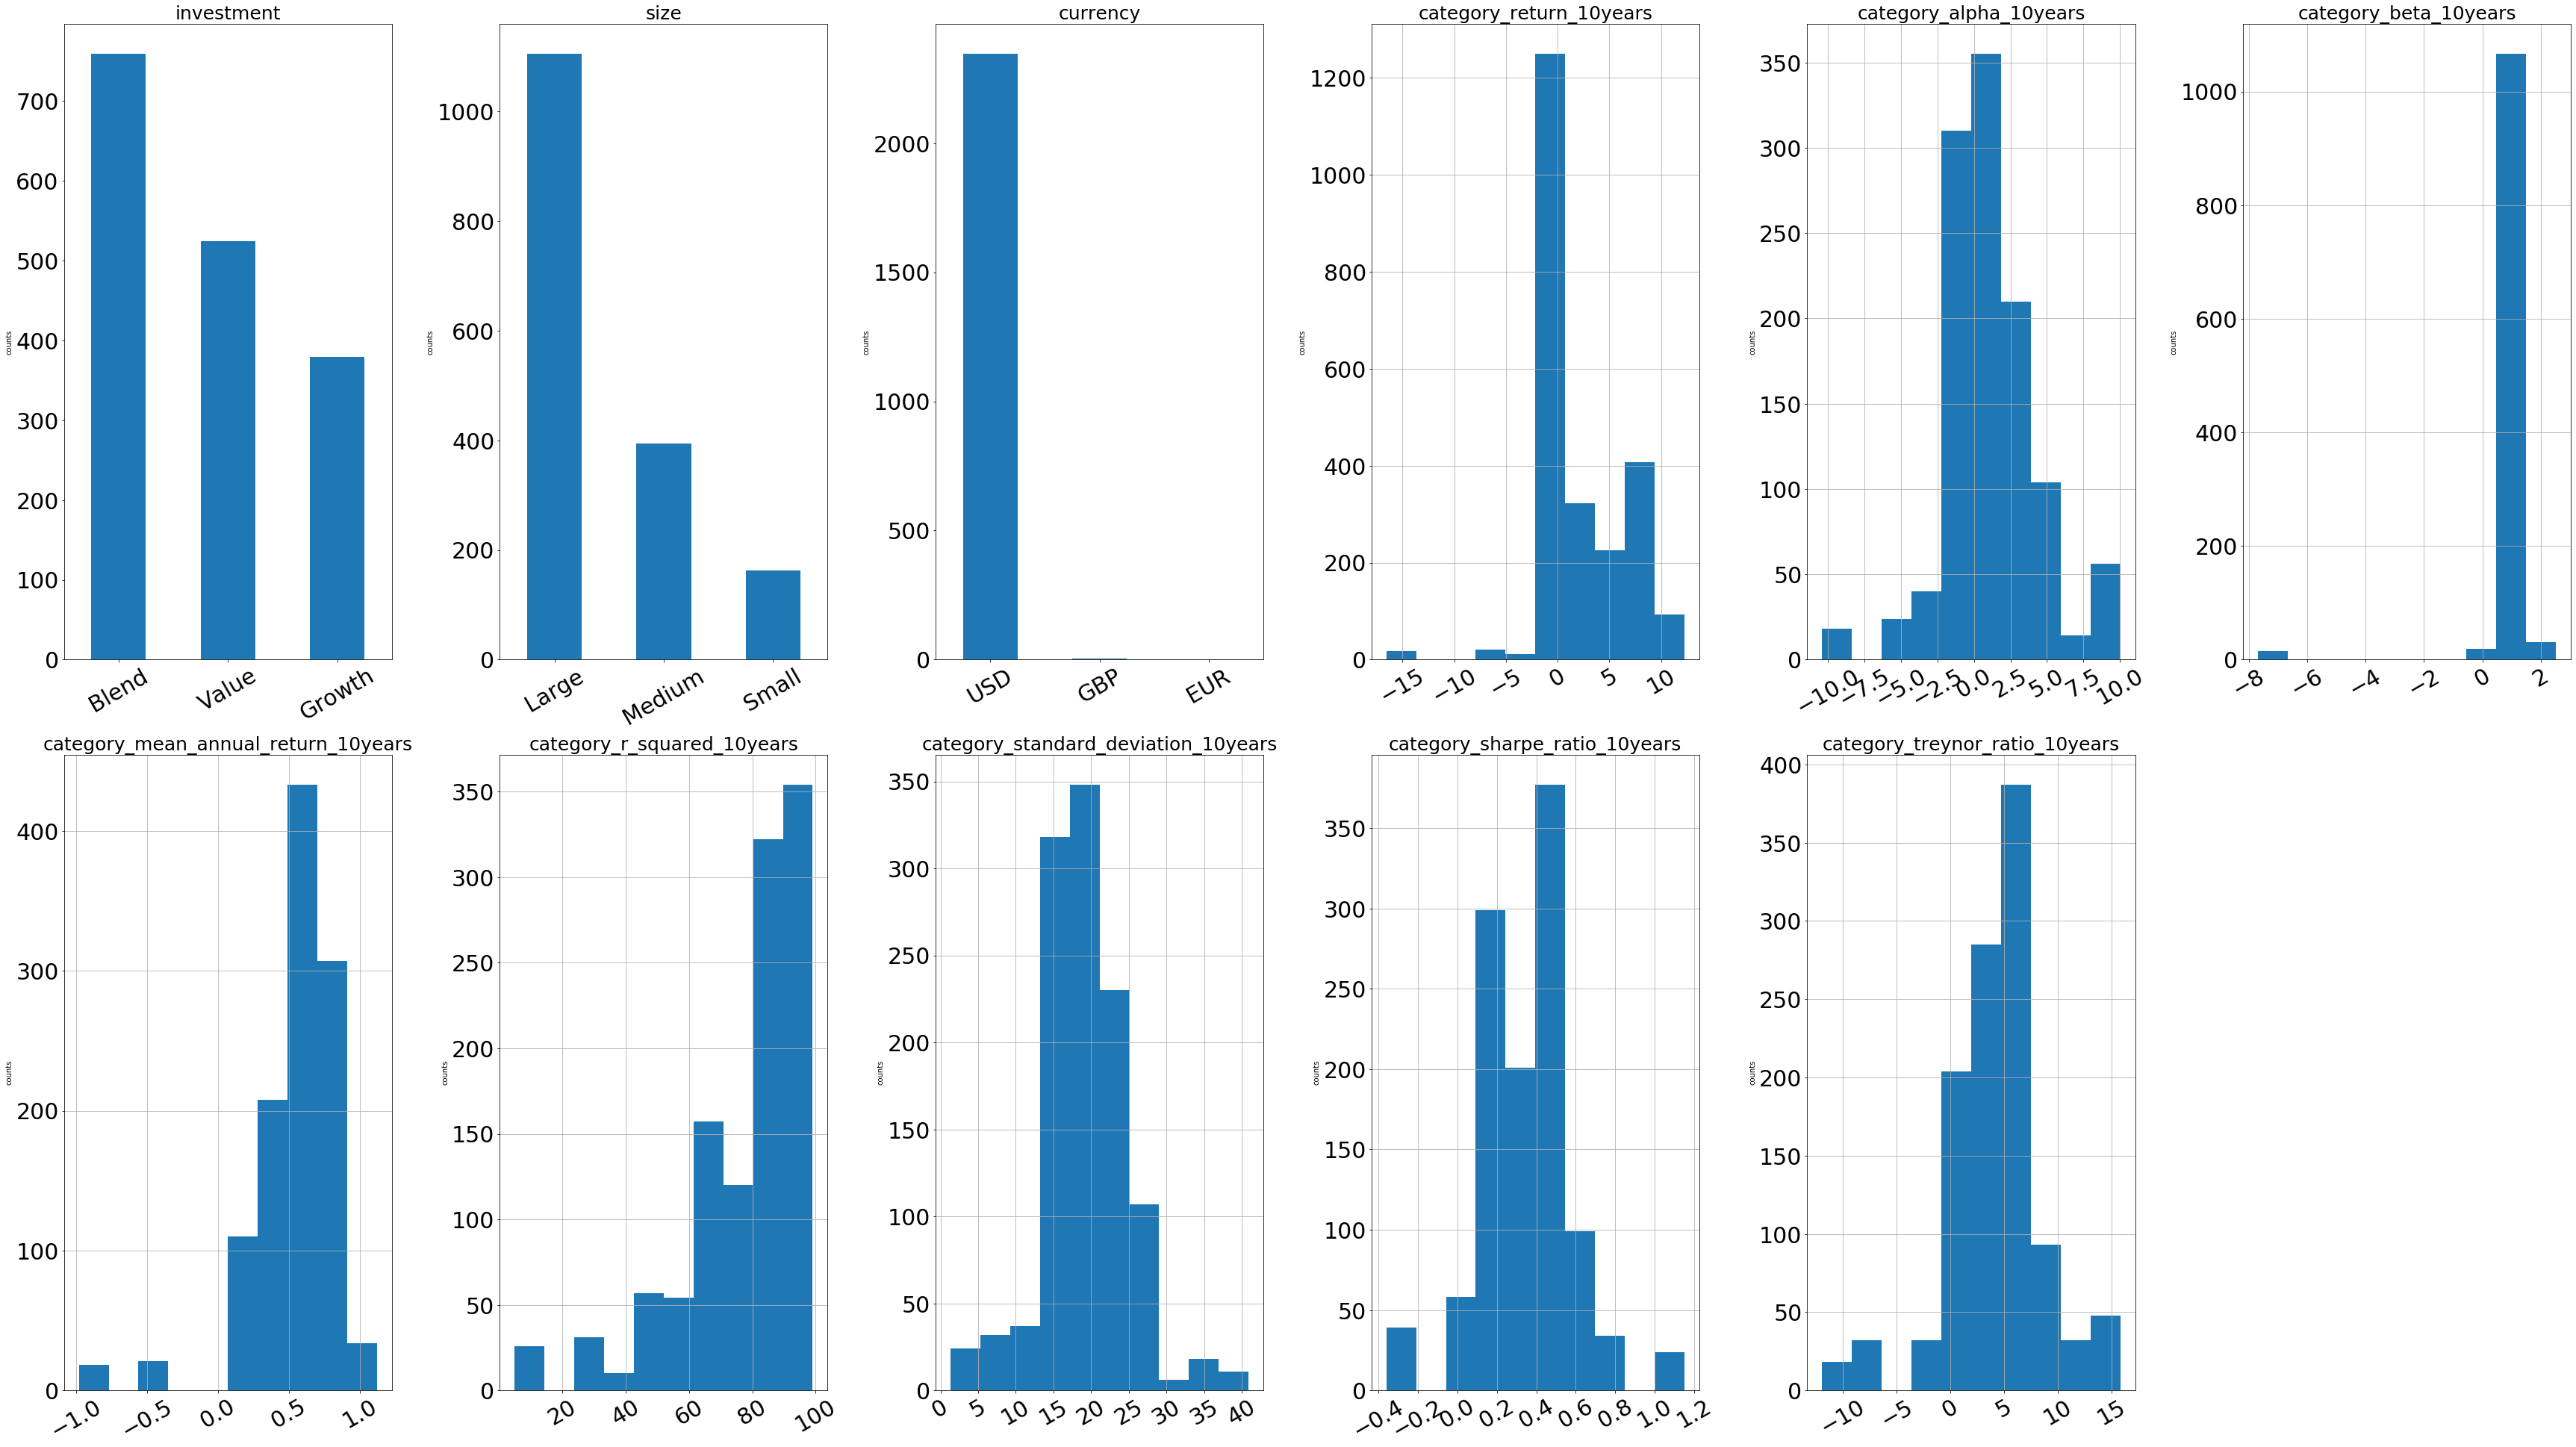

In [11]:
hist_bar_plot(df_etf)

In [12]:
def correlation_clean(df, threshold=(-0.9, -0.3, 0.3, 0.9)):
    # Fix for non-numerical (or too many nan) columns
    col_corr = {
        # ETFs
        'fund_name', 'fund_extended_name', 'category', 'fund_family', 'net_assets', 'legal_type', 'investment', 'size',
        'currency', 'rating_us_government', 'fund_treynor_ratio_3years', 'category_treynor_ratio_5years',
    }
    try:
        for col in col_corr:
            del df[col]
    except KeyError:
        pass  # legal_type

    # Chose numerical columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (not threshold[0] <= corr_matrix.iloc[i, j] <= threshold[1] and
                not threshold[2] <= corr_matrix.iloc[i, j] <= threshold[3]
            ) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in df.columns:
                    del df[colname]

    return df

In [13]:
df_etf = correlation_clean(df_etf)

In [14]:
def corr_mtx(df, fig_size=50, unique=True):
    sns.set(font_scale=4.0)
    # Chose adequate columns for visualization
    if unique:
        num_unique_col = df.nunique()
        df = df[[col for col in df if num_unique_col[col] > 1]]

    f, ax = plt.subplots(figsize=(fig_size, fig_size))
    corr = df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    plt.show()
    sns.set(font_scale=2.0)
    

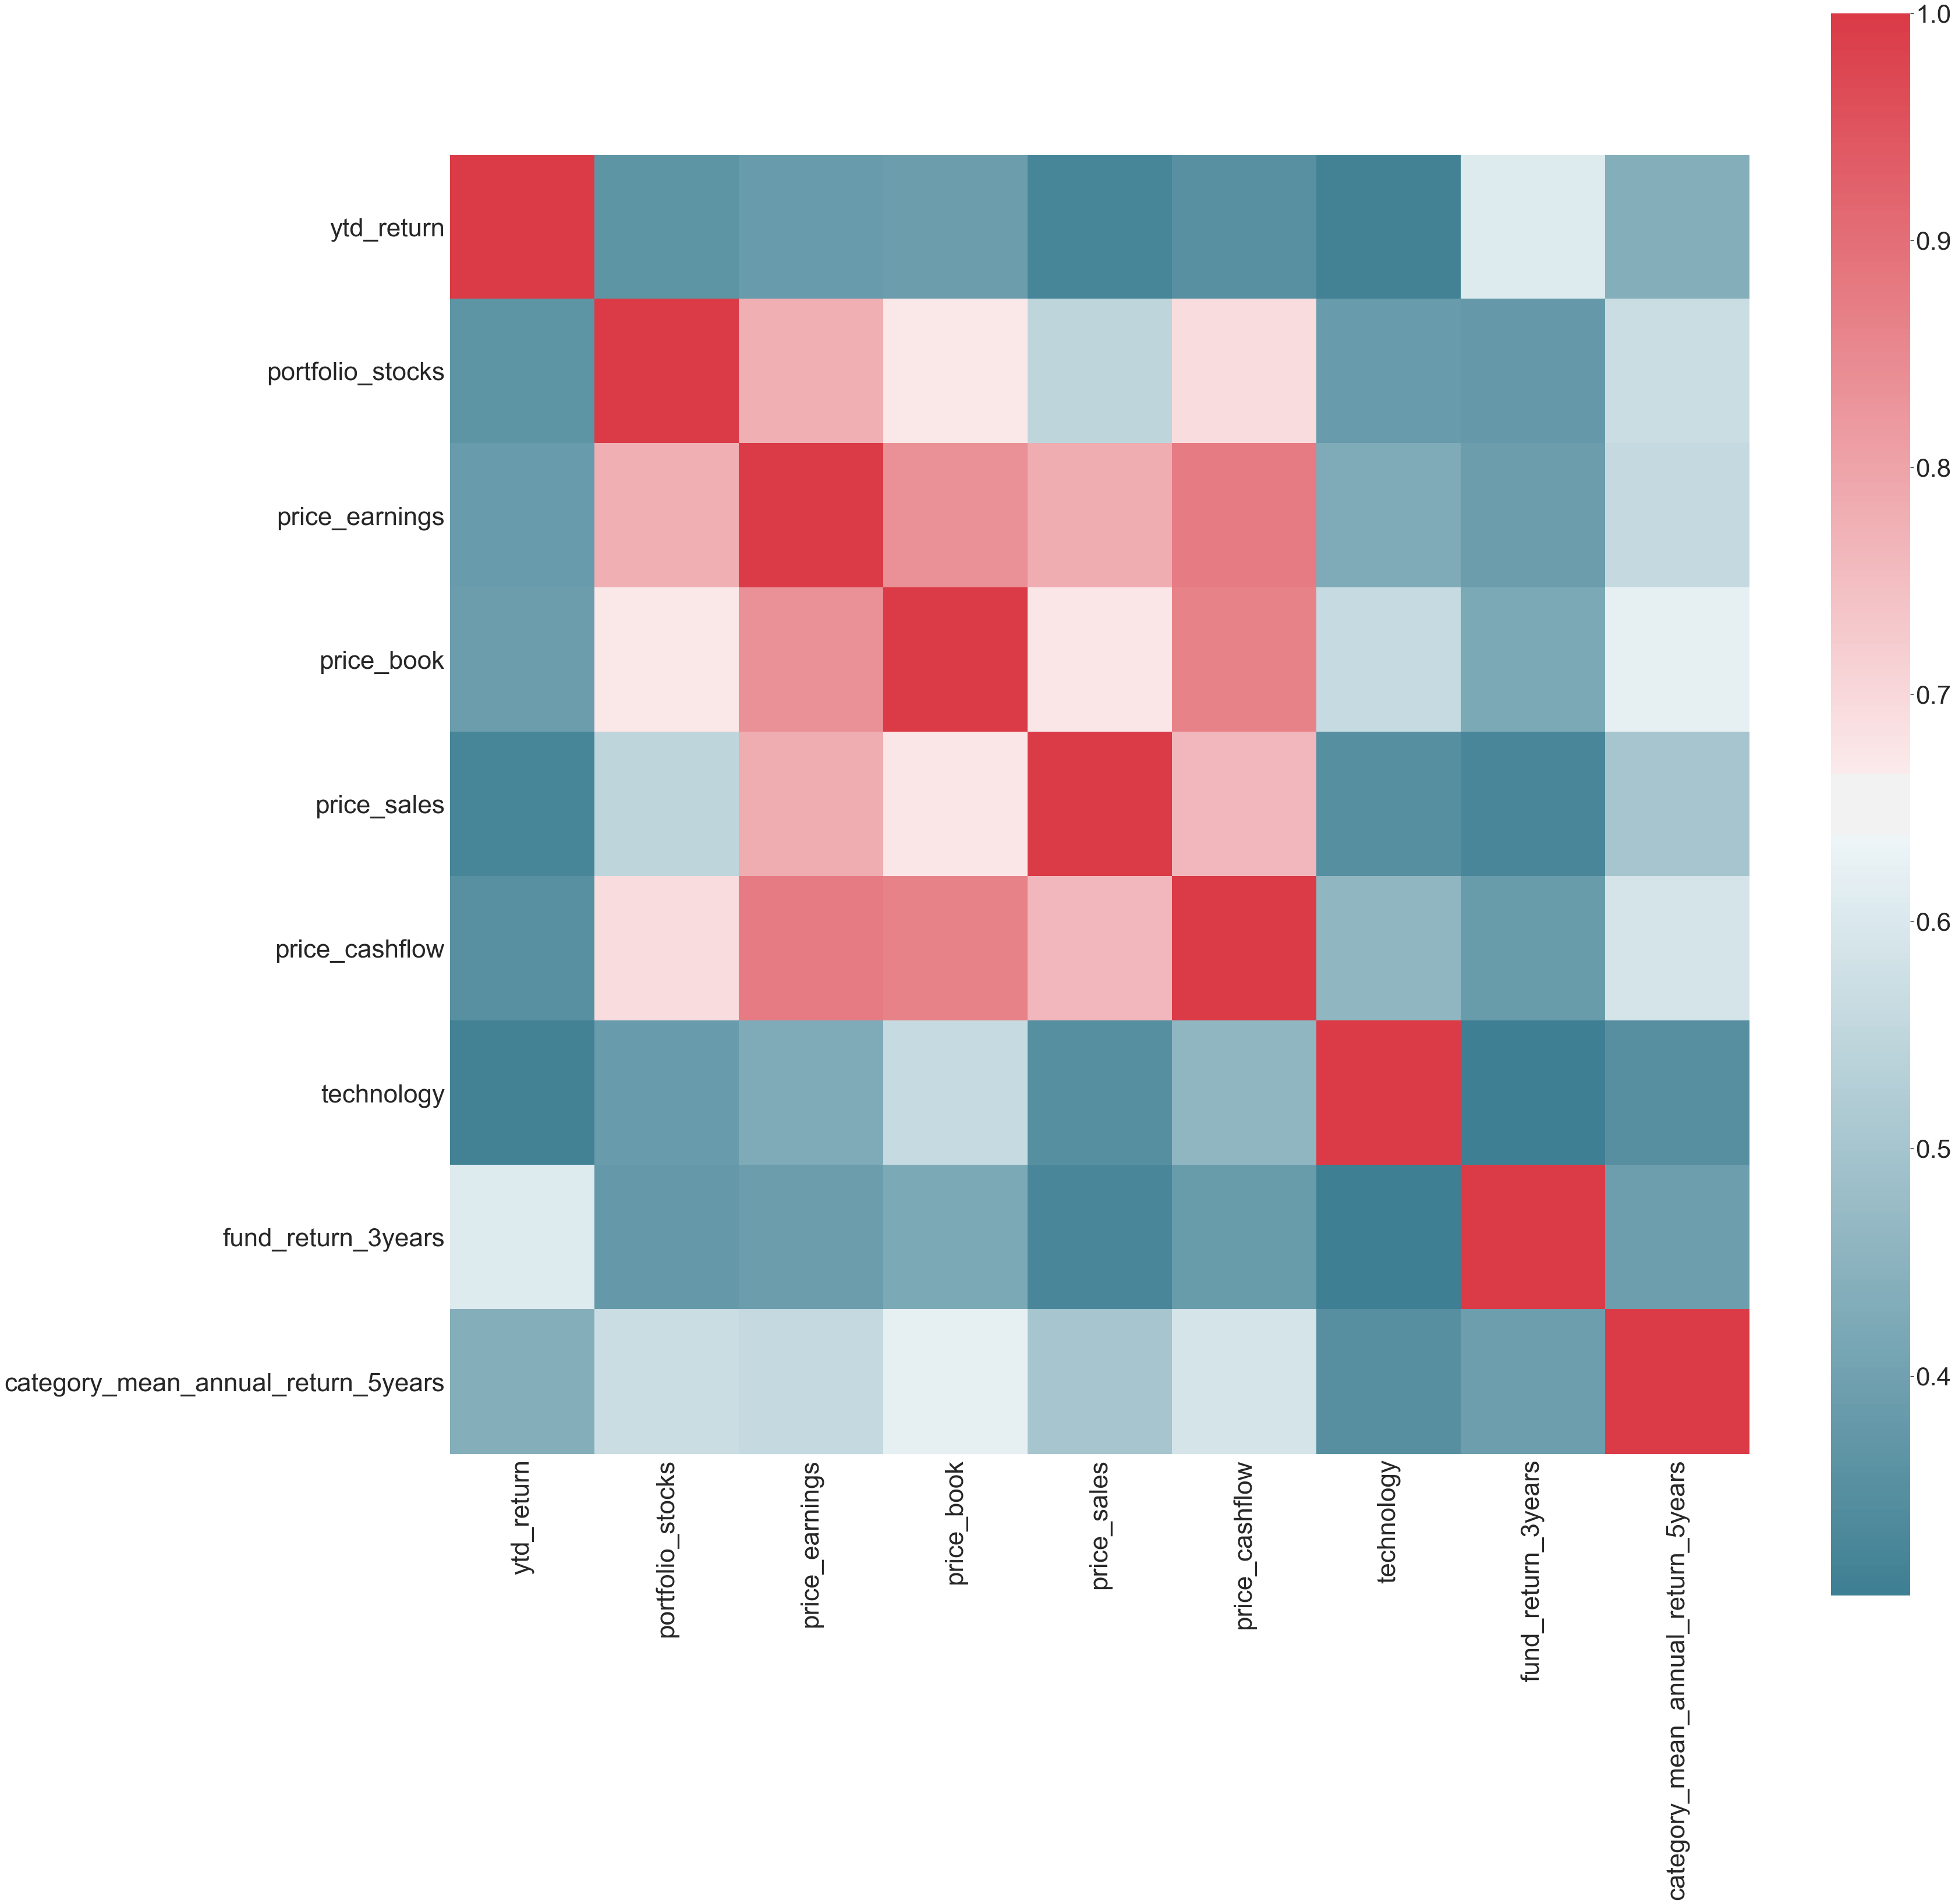

In [15]:
corr_mtx(df_etf, unique=False)

In [16]:
def scatter_mtx(df, figsize=50, cap=10):
    df = df.select_dtypes(np.number)
    if len(list(df)) > cap:
        df = df[list(df)[:cap]]
    scatter_matrix = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(figsize, figsize), diagonal='kde')
    for ax in scatter_matrix.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize=30, rotation=90)
        ax.set_ylabel(ax.get_ylabel(), fontsize=30, rotation=0)
    plt.show()

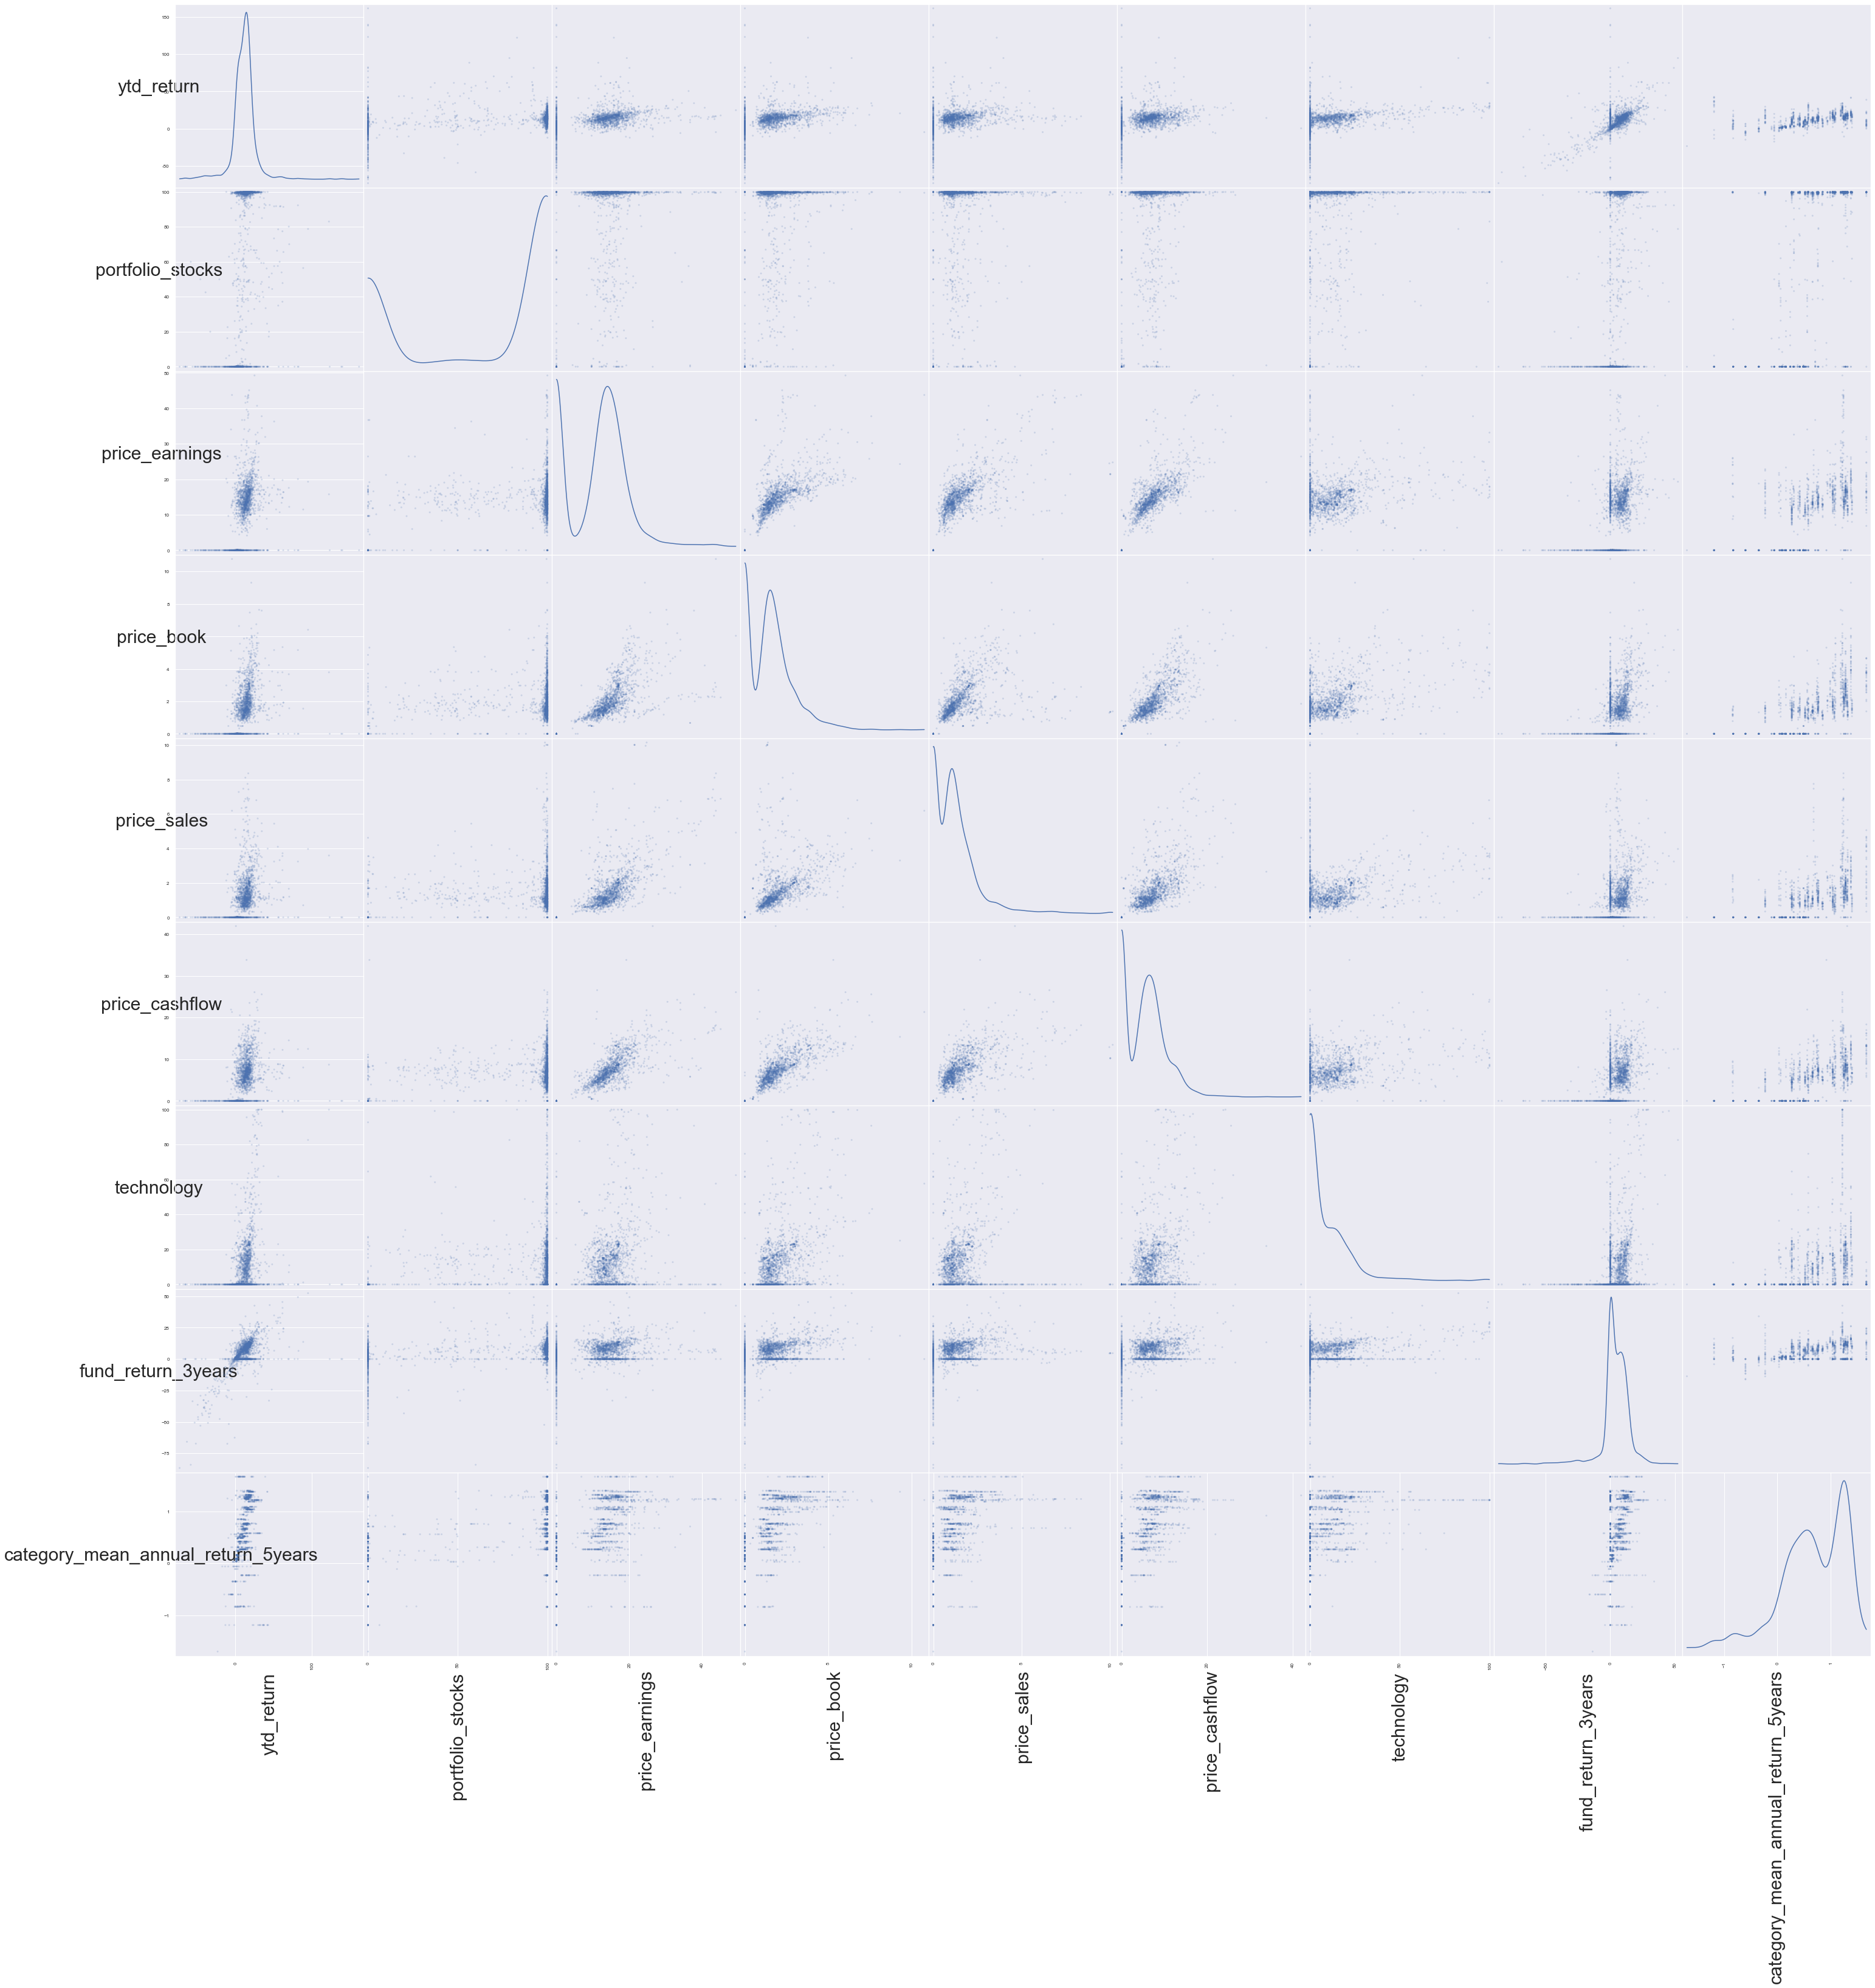

In [17]:
scatter_mtx(df_etf)

### MF Visualization

In [18]:
# types(df_mf)

In [19]:
# describe(df_mf)

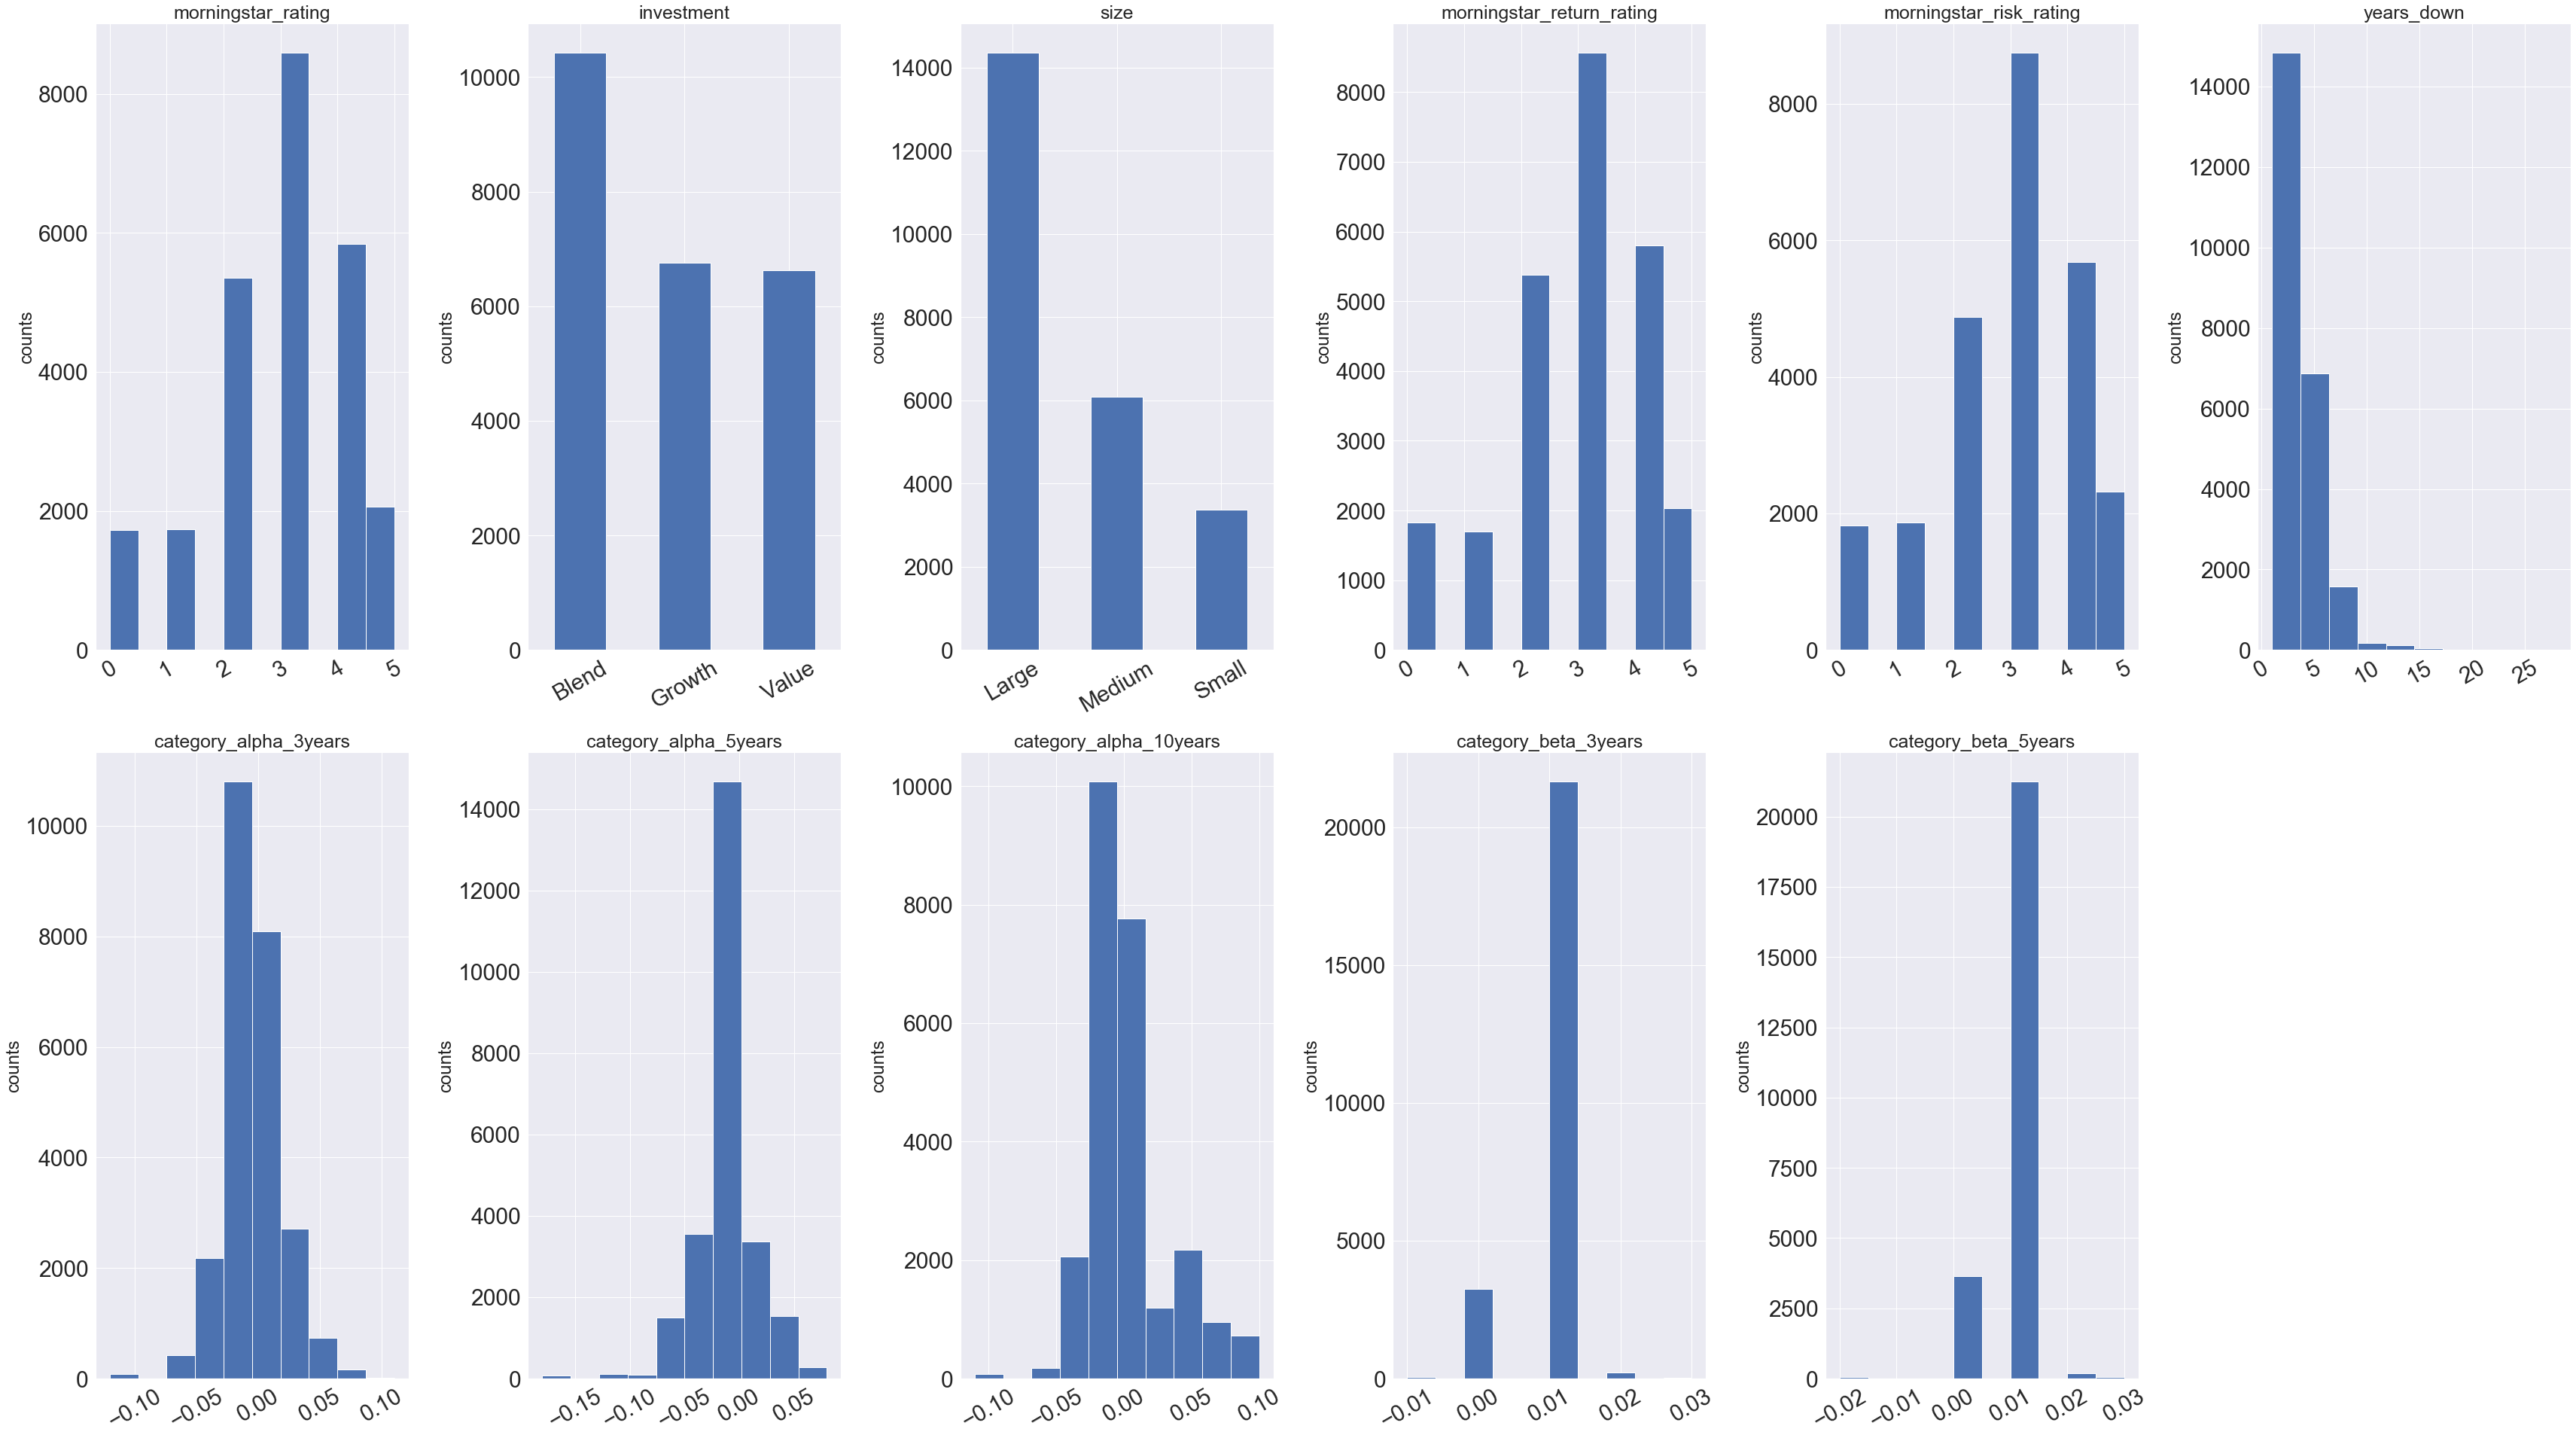

In [20]:
hist_bar_plot(df_mf)

In [21]:
df_mf = correlation_clean(df_mf, threshold=(-0.9, -0.6, 0.6, 0.9))

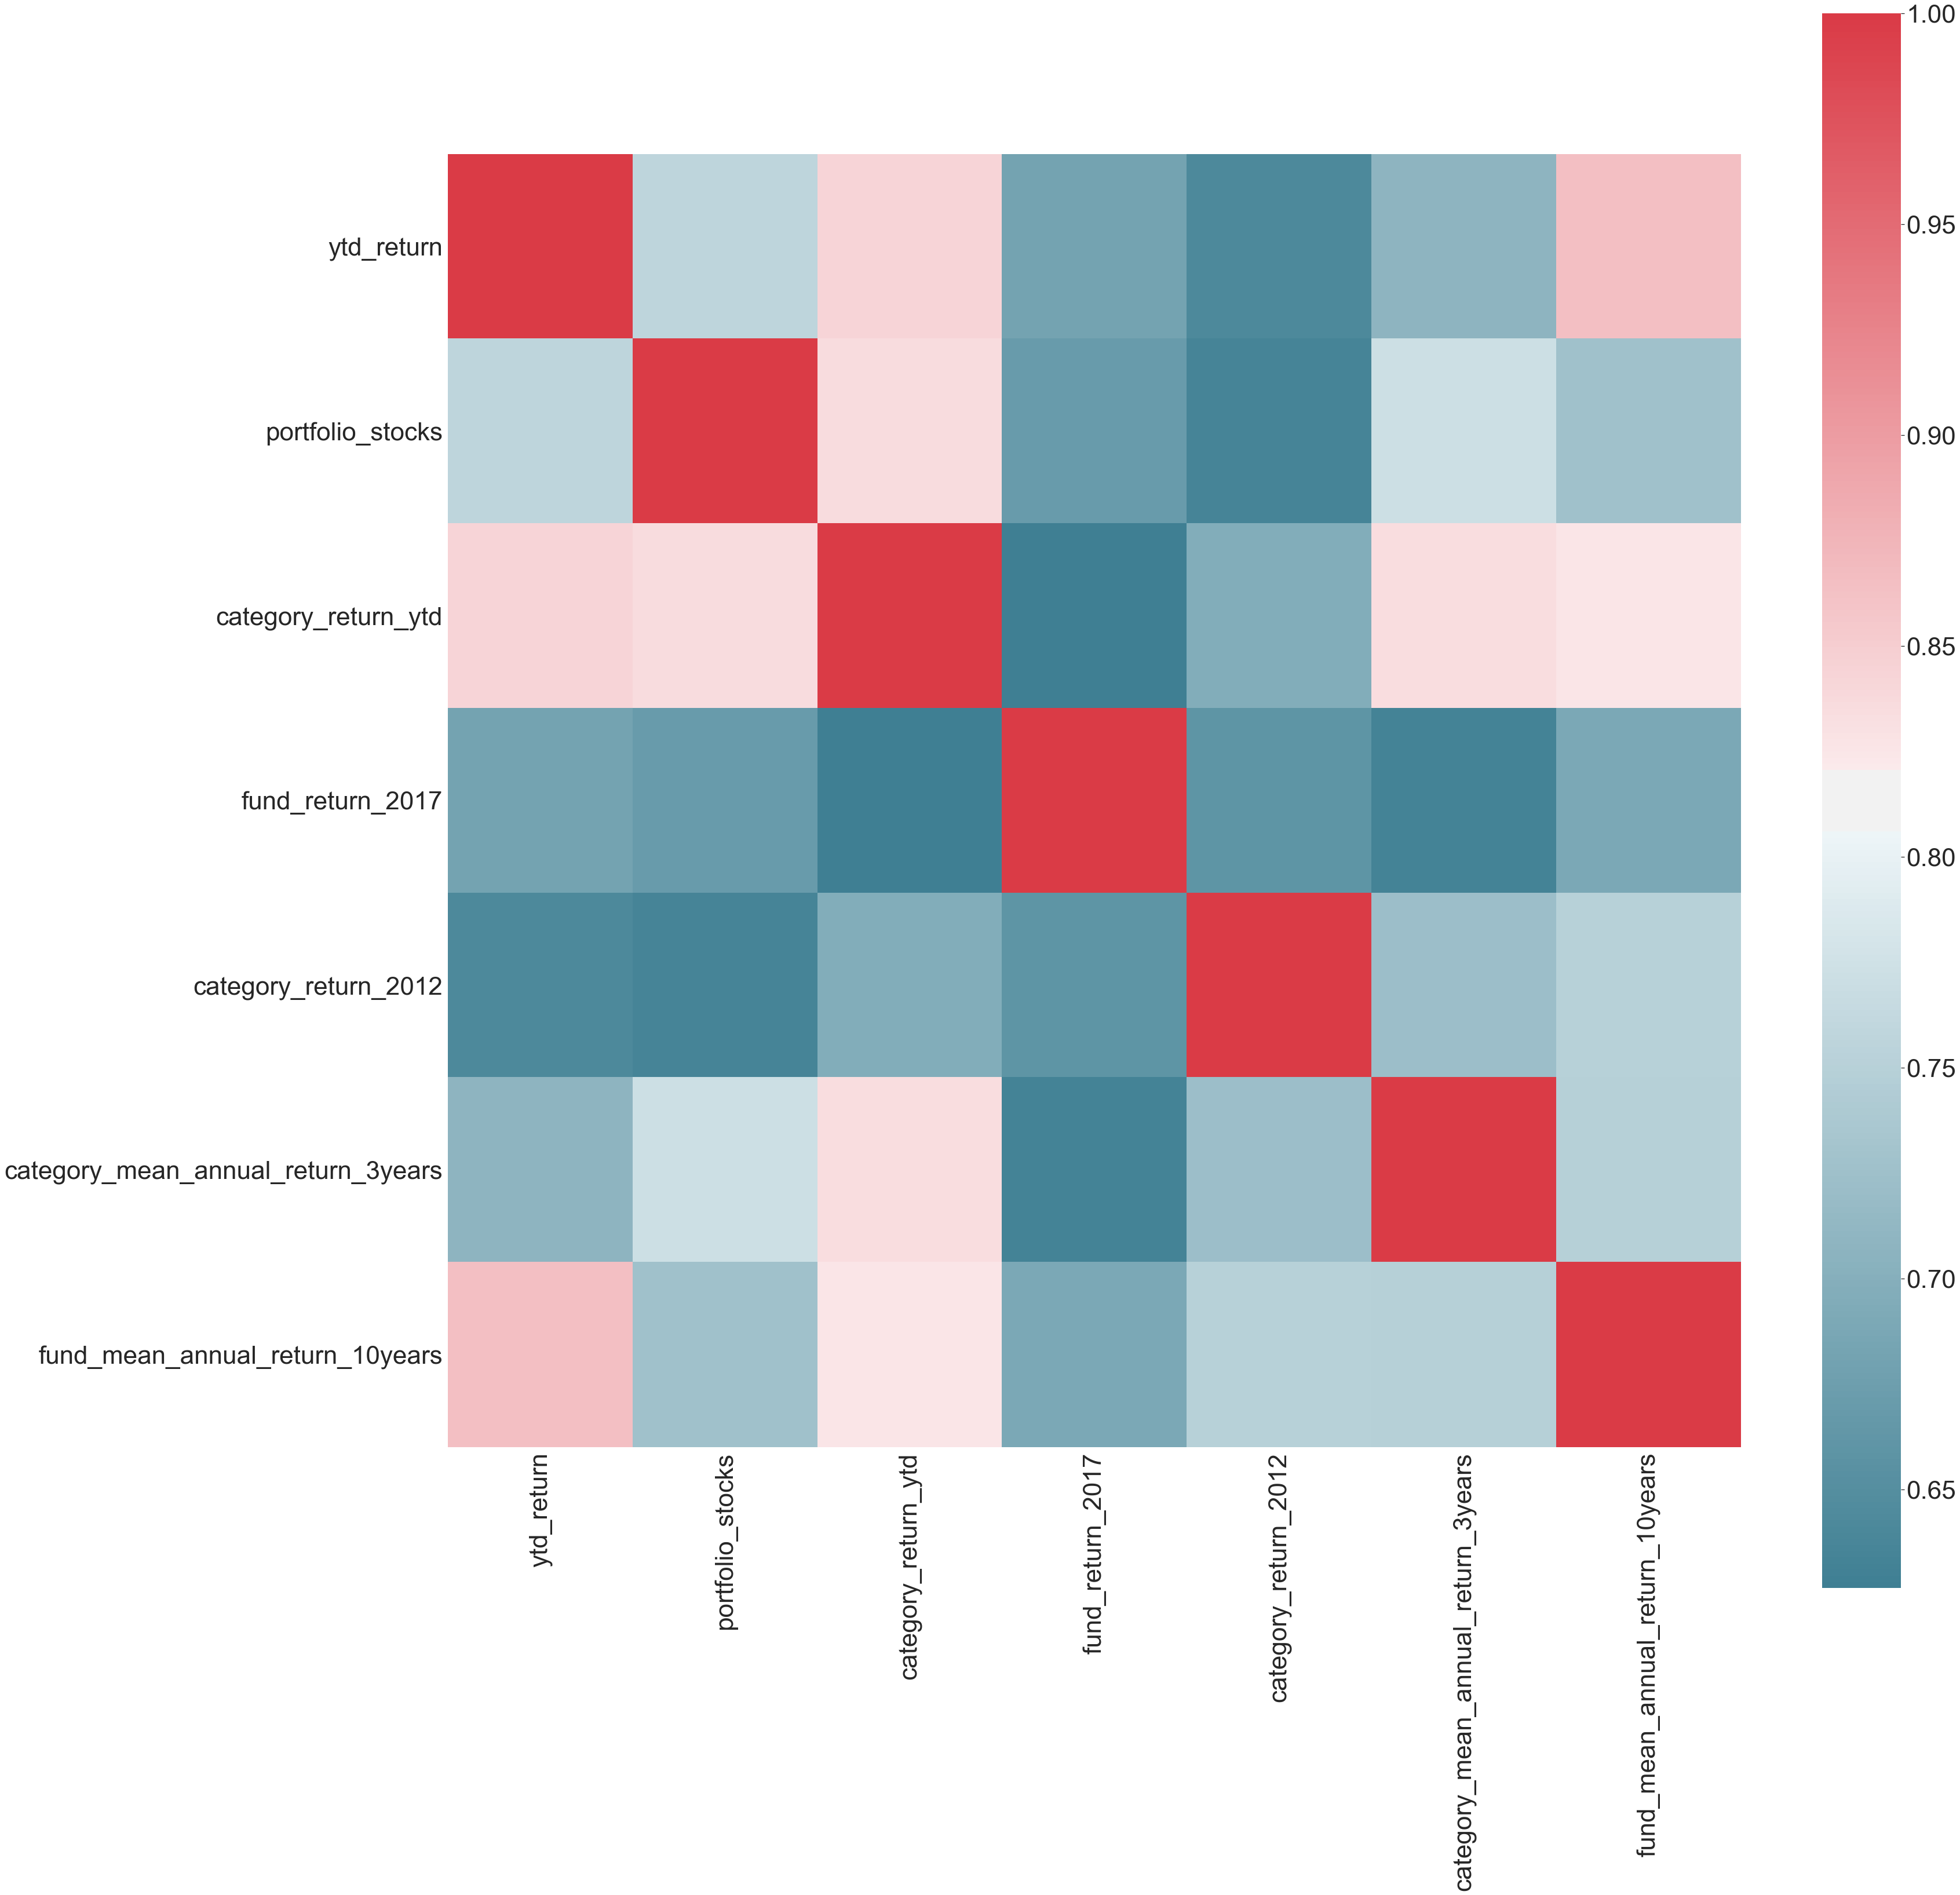

In [22]:
corr_mtx(df_mf, unique=False)

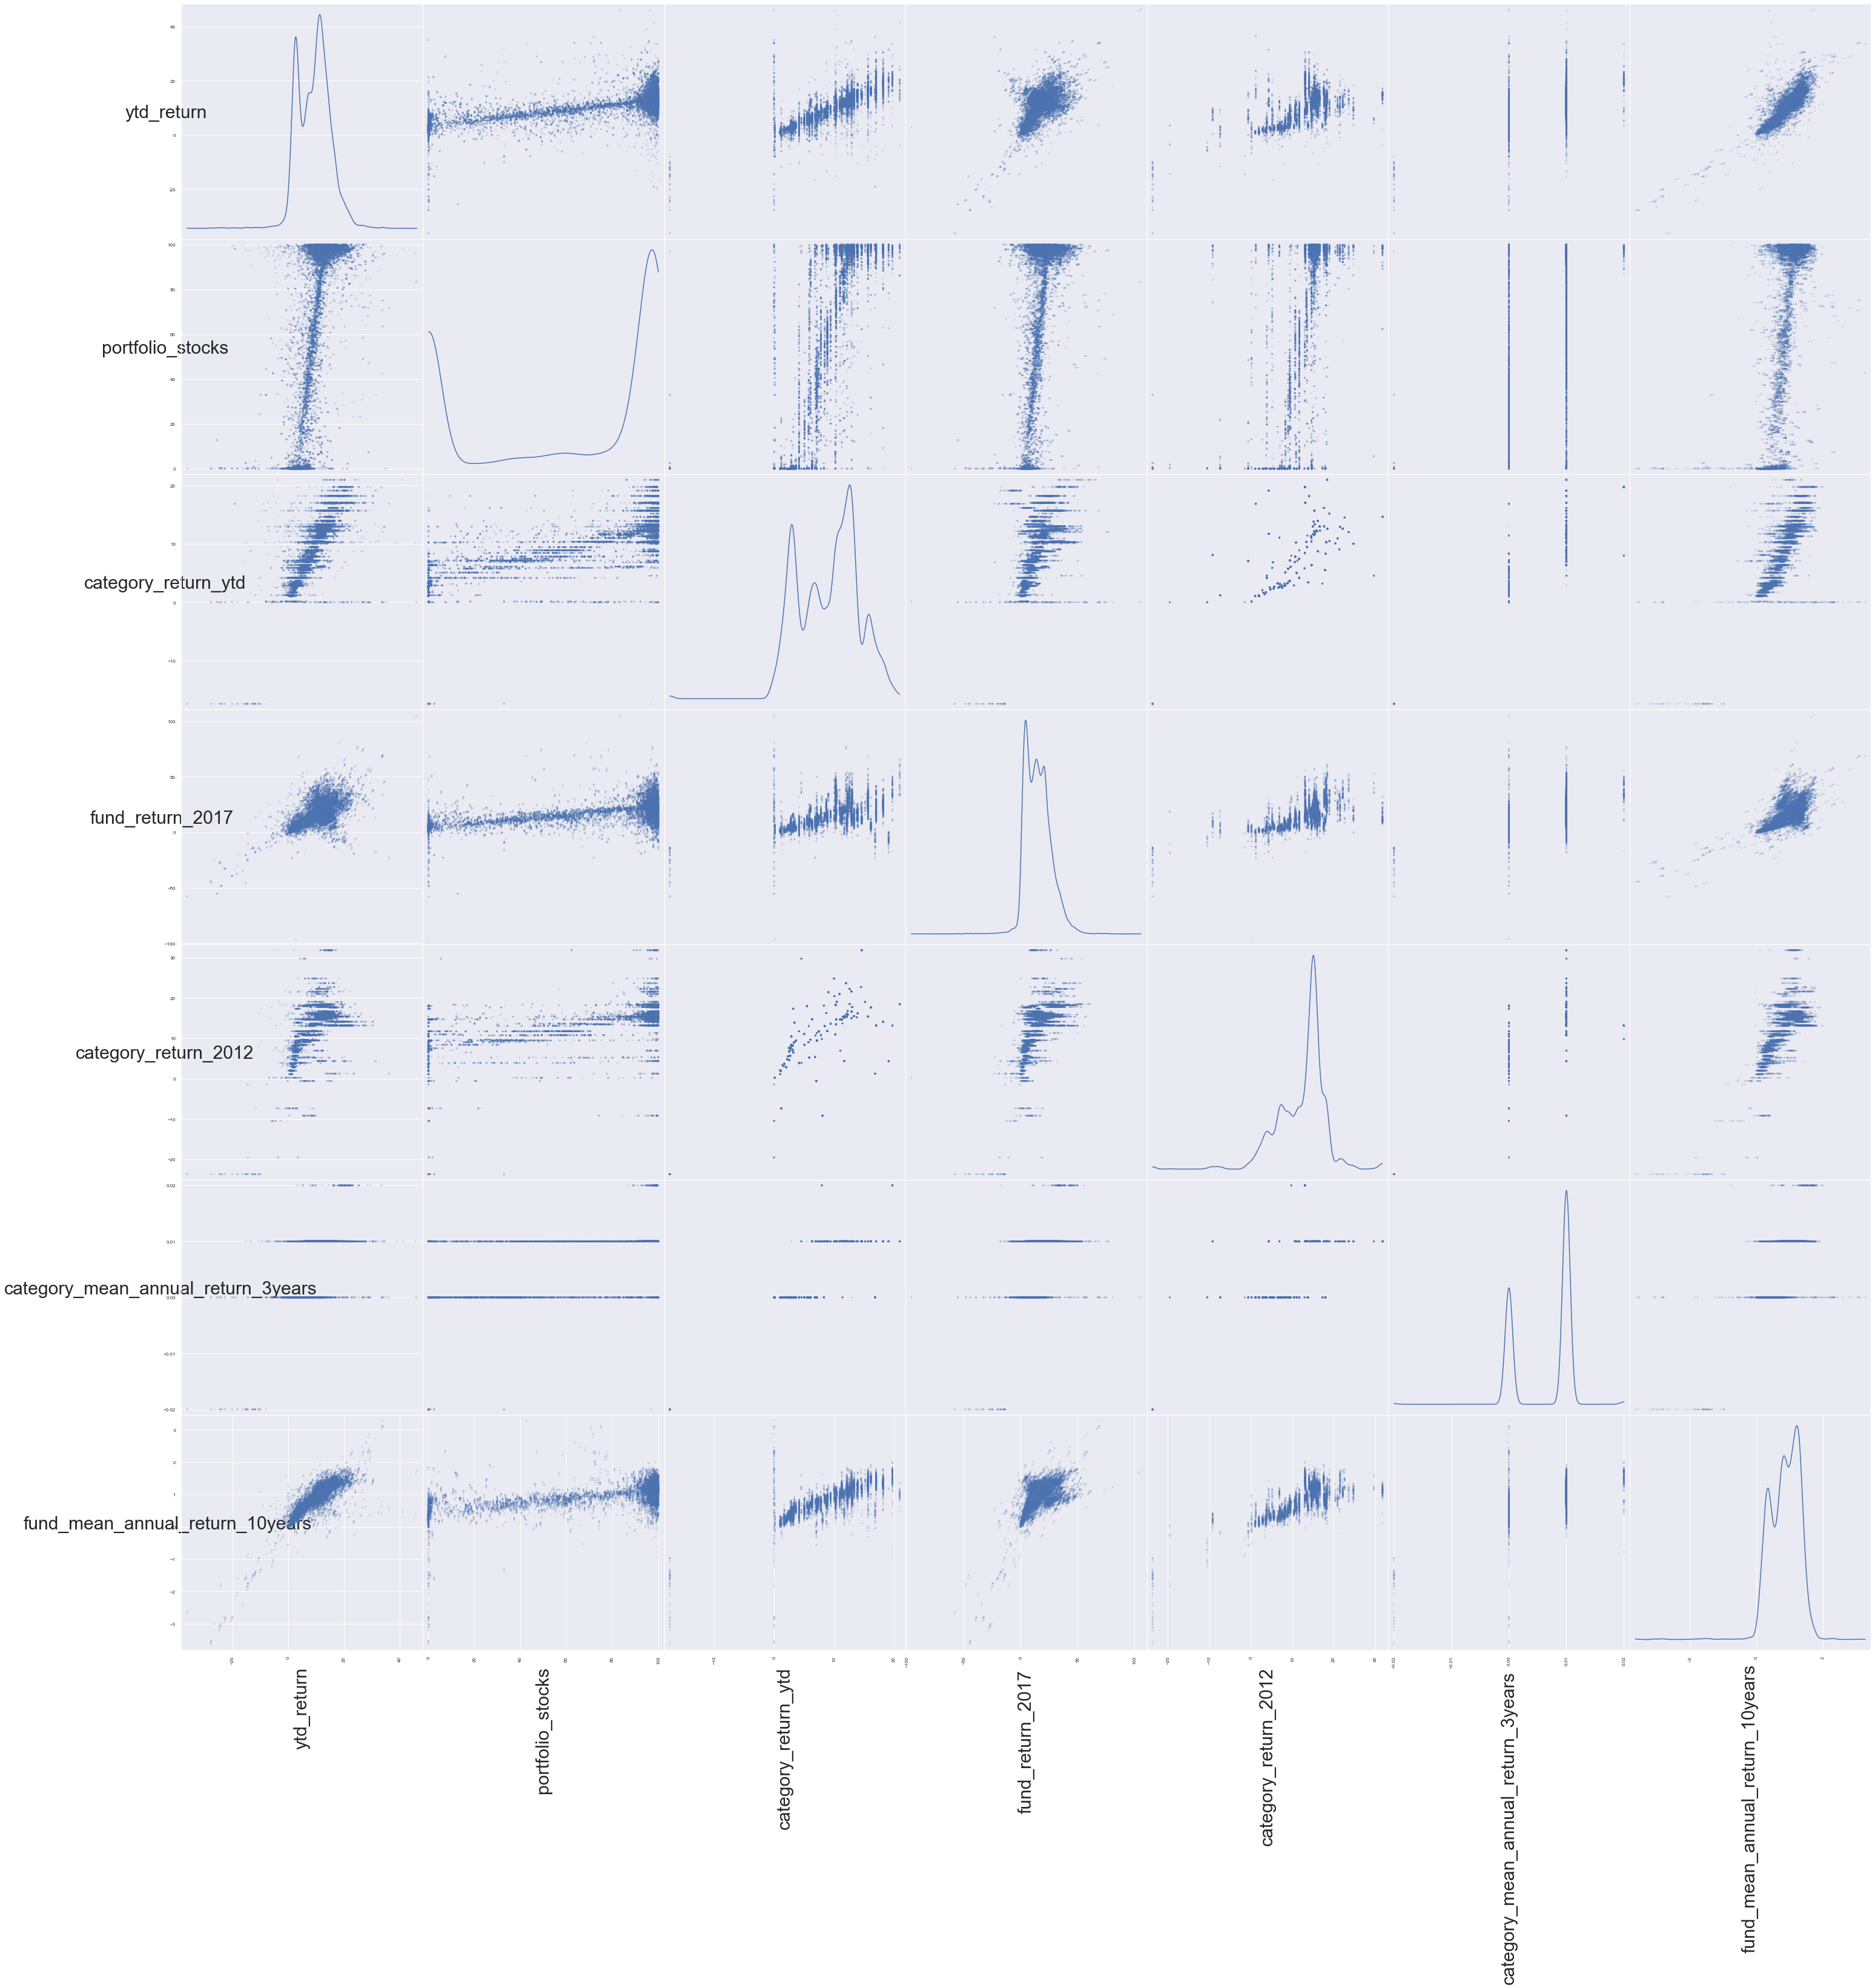

In [23]:
scatter_mtx(df_mf, cap=20)

### Dataset Cleaning

In [24]:
df_etf, df_mf = load_dataset() # Load again because of 'correlation_clean' function

C:\Users\NVukobrat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (20,22,23,119,121,123) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [25]:
def gaussian_clean(df, dataset_type):
    """

    :param df:
    :param dataset_type: etf or mf.
    :return:
    """
    # Fix NaN
    df.replace('', 'NaN', inplace=True)
    df.replace('nan', 'NaN', inplace=True)
    df.replace('NaN', np.nan, inplace=True)

    # As consequence of too many NaN values
    migrate_columns = [
        'fund_treynor_ratio_3years',
    ]
    if dataset_type == 'etf':
        migrate_columns += [
            'category_treynor_ratio_5years',
        ]
    elif dataset_type == 'mf':
        migrate_columns += [
            'price_cashflow',
            'price_sales',
            'price_earnings',
            'median_market_cap',
            'fund_treynor_ratio_5years',
            'fund_treynor_ratio_10years',
        ]

    # Join together numerical columns
    num_mean = df.select_dtypes(np.number)
    for col in migrate_columns:
        num_mean = num_mean.join(pd.to_numeric(df[col], errors="coerce"))

    # Columns with low-value information (ignored during initial analysis)
    low_info_categorical_columns = [
        'category',
        'currency',
        'fund_extended_name',
        'fund_family',
        'fund_name',
    ]
    if dataset_type == 'etf':
        low_info_categorical_columns += [
            'legal_type',
        ]
    elif dataset_type == 'mf':
        low_info_categorical_columns += [
            'inception_date',
        ]

    # Join together categorical (without low-value) columns
    str_mean = df[df.columns.difference(num_mean.columns)]
    for col in low_info_categorical_columns:
        str_mean = str_mean.drop(col, axis=1)

    # Populate empty values in categorical columns
    for col in list(str_mean):
        unique = str_mean[col].unique()
        unique = [x for x in unique if str(x) != 'nan']
        for i, value in enumerate(str_mean[col]):
            if value is np.nan:
                choice = random.choice(unique)
                str_mean[col].iloc[i] = choice

    # Encode categorical columns
    le = LabelEncoder()
    for col in str_mean:
        df[col] = le.fit_transform(str_mean[col])

    # One-hot encode categorical columns
    ohe = OneHotEncoder()
    for col in str_mean:
        unique = str_mean[col].unique()
        unique = [col + "_" + x for x in unique if str(x) != 'nan']
        enc_df = pd.DataFrame(ohe.fit_transform(df[[col]]).toarray(), columns=unique)
        df = df.drop(col, axis=1)
        df = df.join(enc_df)

    mu = num_mean.quantile(0)
    sigma = num_mean.std(axis=0)
    for col in num_mean:
        stack = num_mean[col]
        null_stack = stack[pd.isnull(stack)]
        ran = np.random.normal(mu[col], sigma[col], len(null_stack))
        stack.loc[null_stack.index] = ran
        df[col] = stack.values

    # Clean
    df_dropped = pd.DataFrame()
    for col in low_info_categorical_columns:
        df_dropped[col] = df[col].copy()
        df = df.drop(col, axis=1)

    return df, df_dropped

In [26]:
df_etf, df_etf_dropped = gaussian_clean(df_etf, 'etf')
   

In [27]:
   
df_mf, df_mf_dropped = gaussian_clean(df_mf, 'mf')

C:\Users\NVukobrat\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Visualize after cleaning

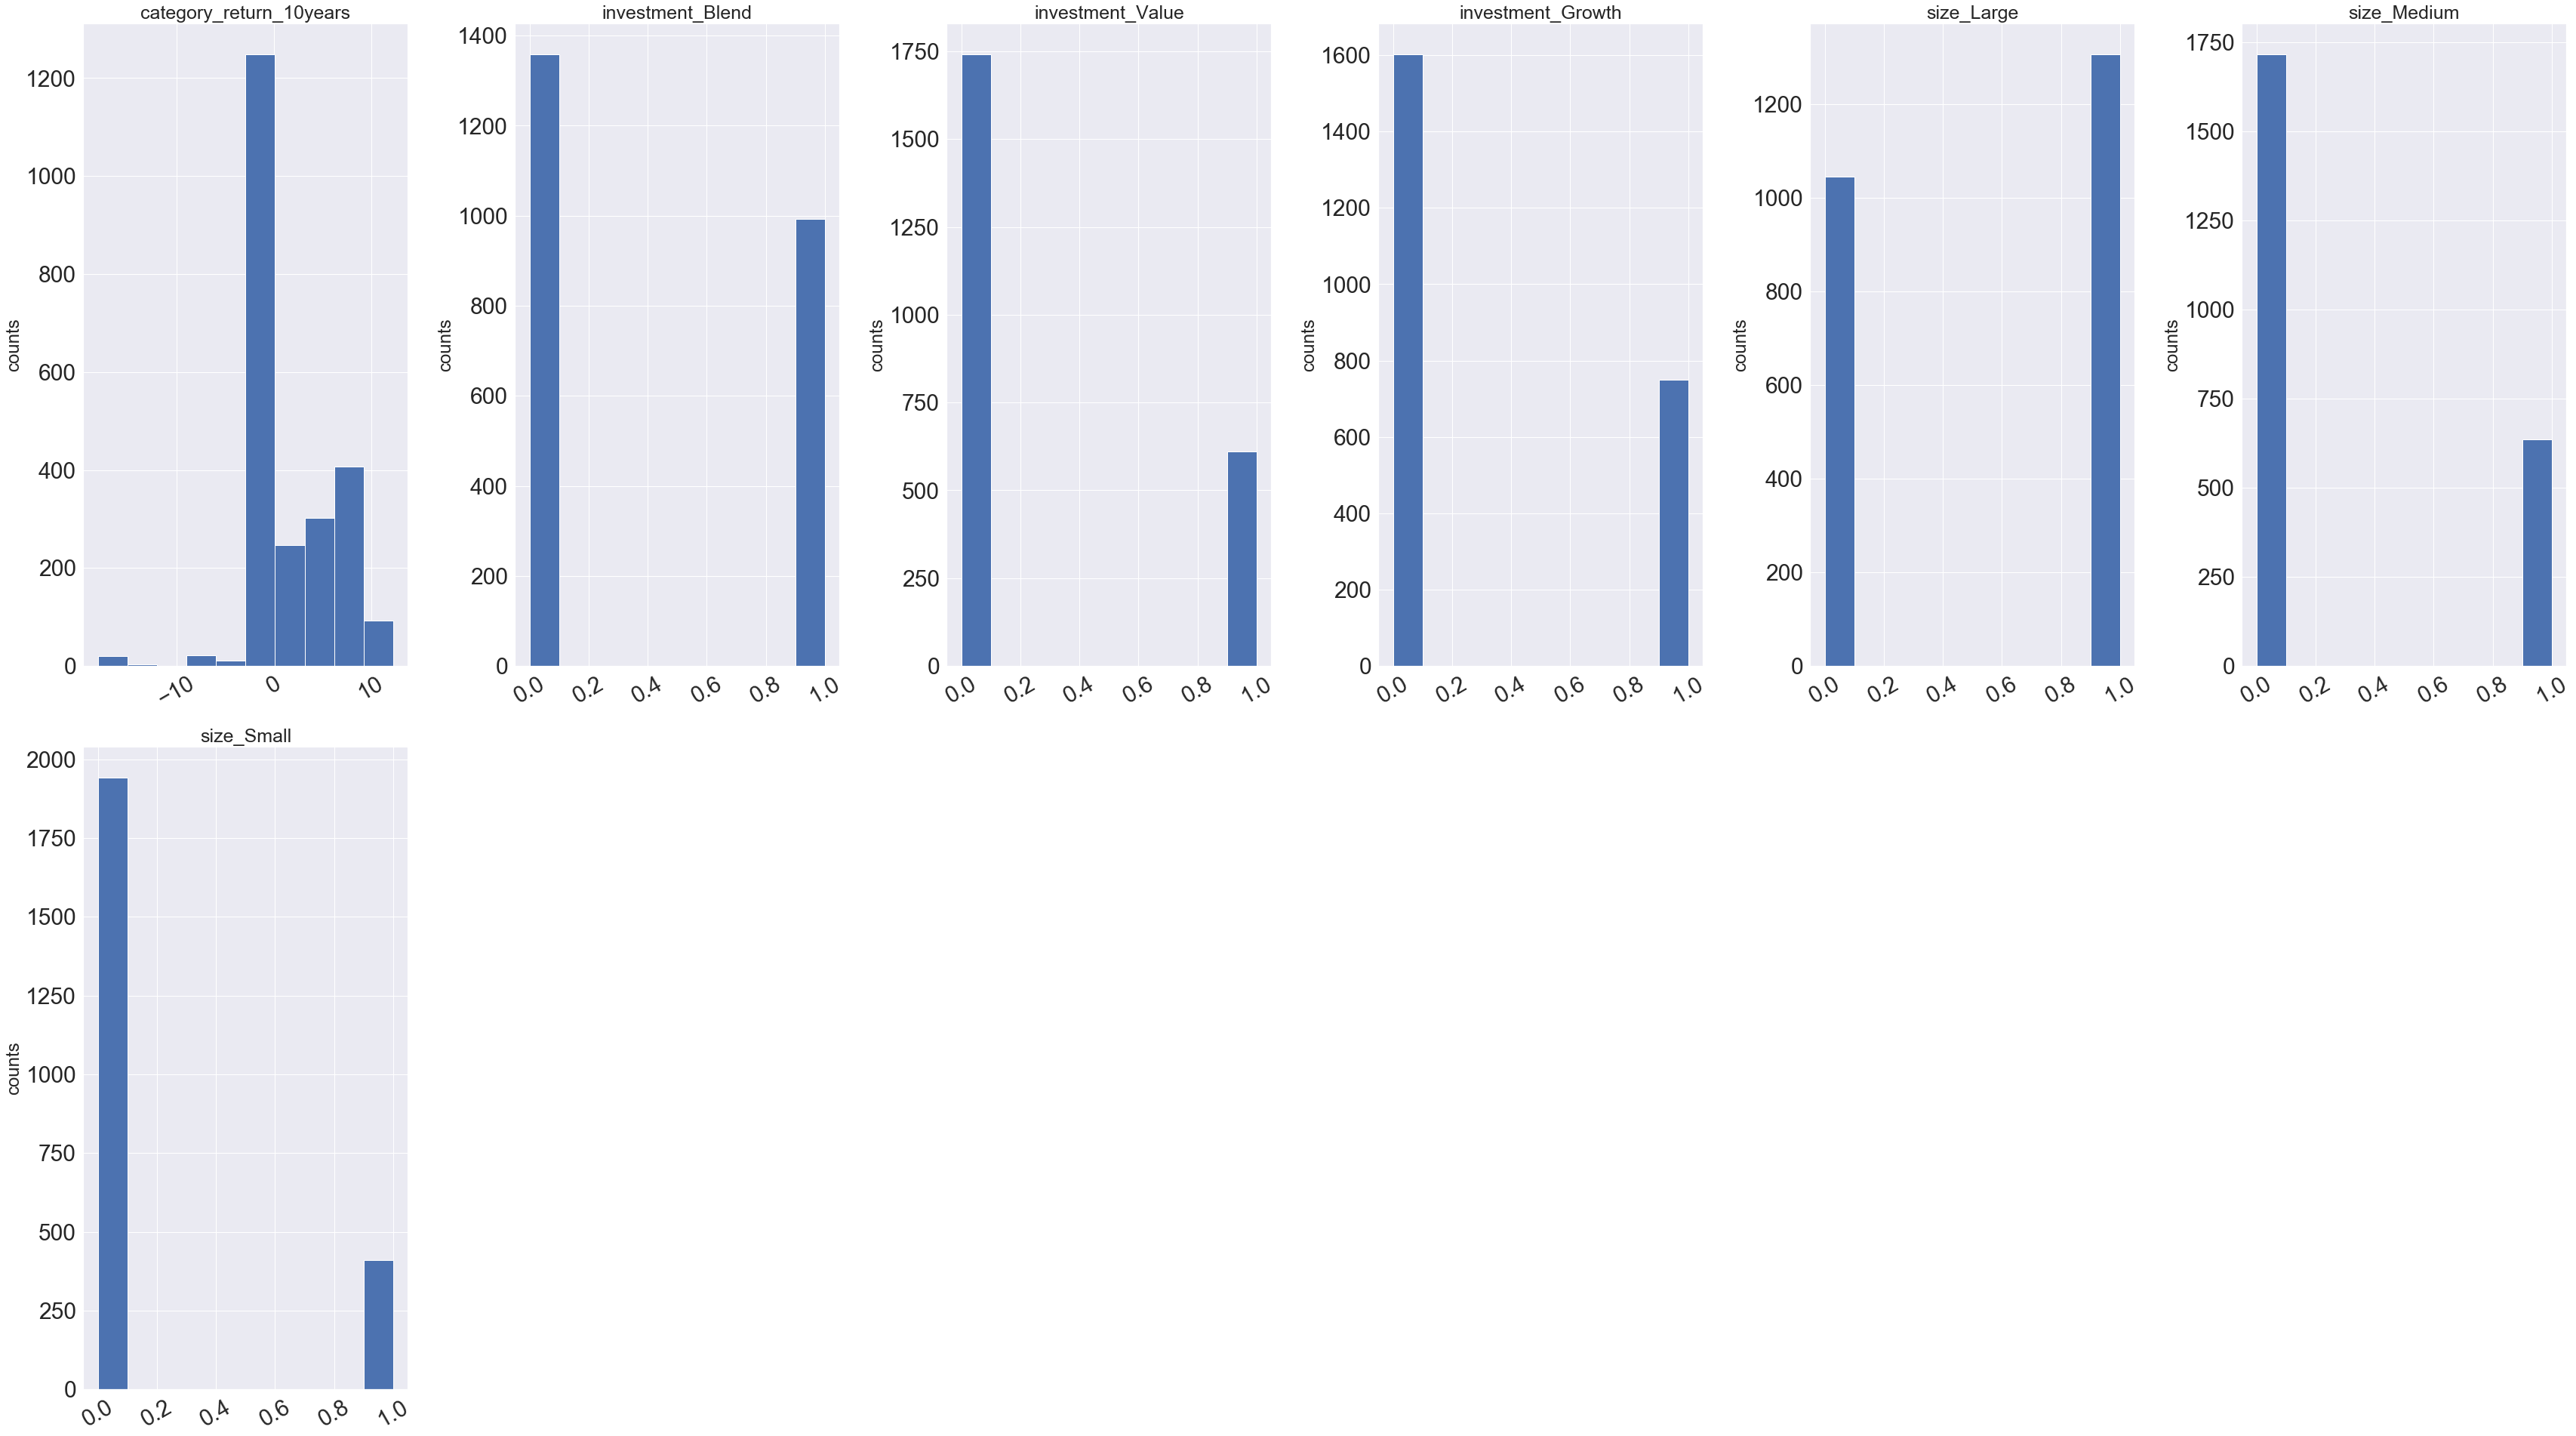

In [28]:
hist_bar_plot(df_etf)

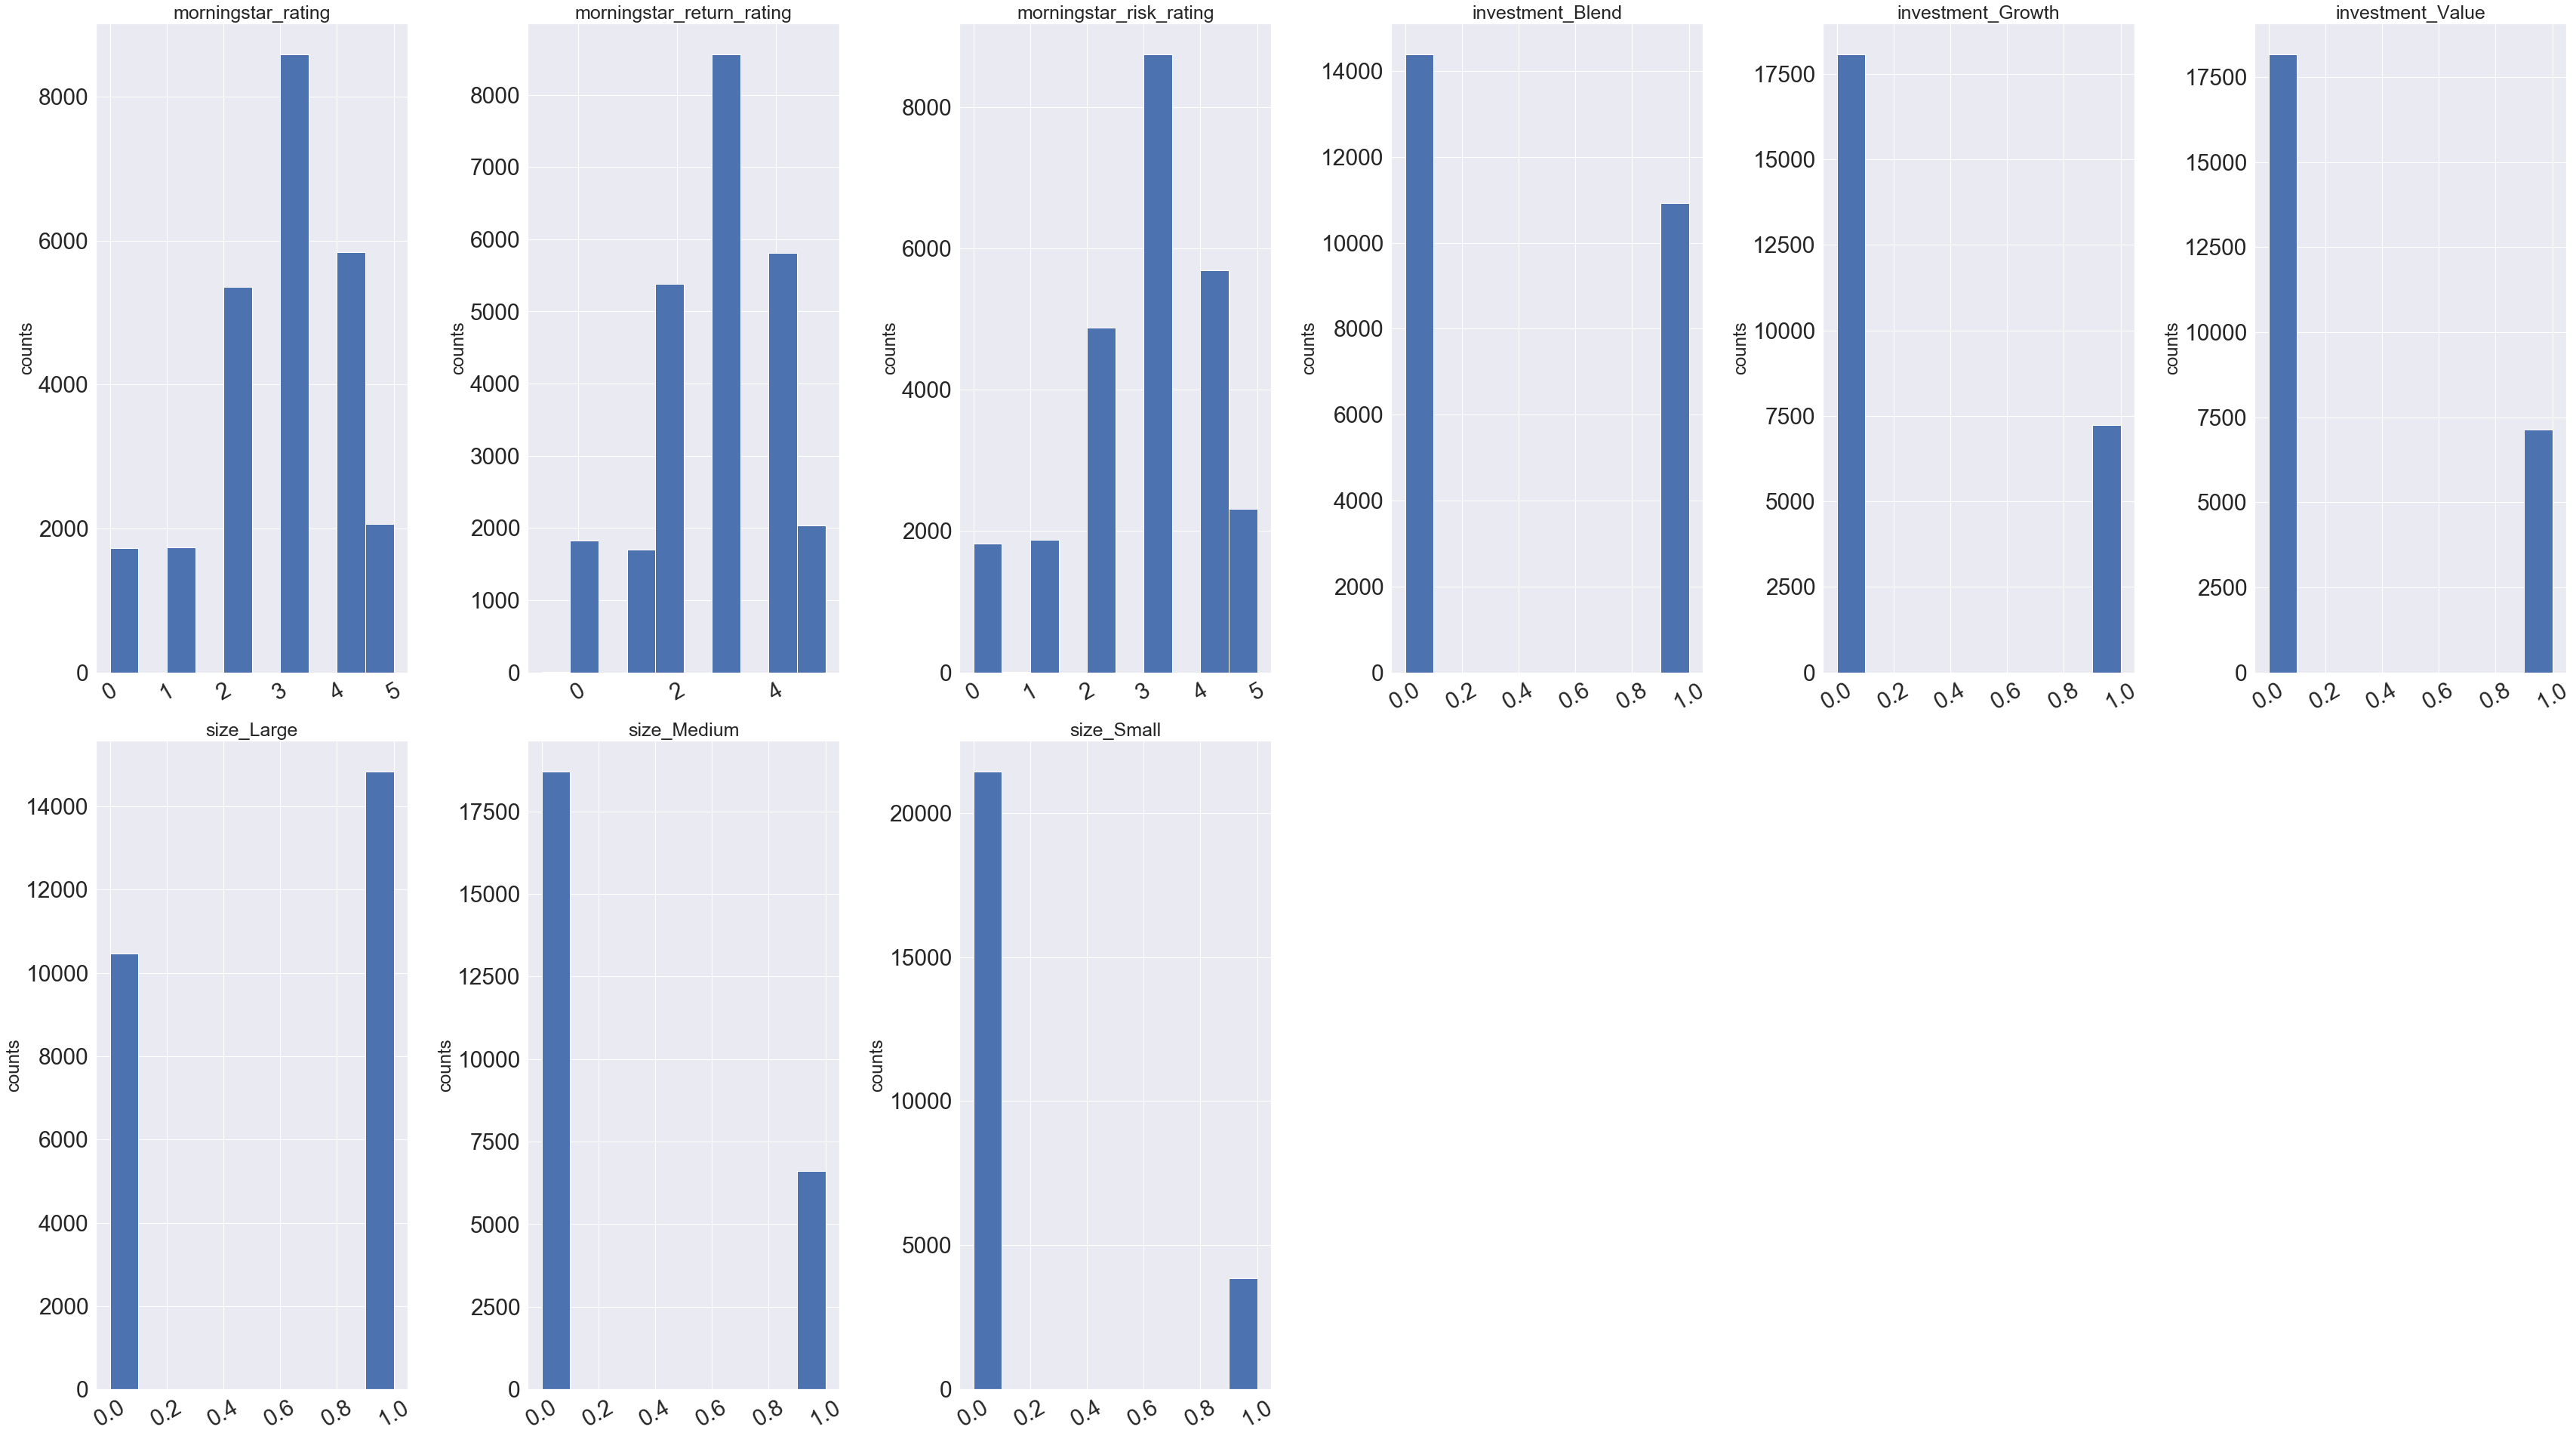

In [29]:
hist_bar_plot(df_mf)

### Training

In [30]:
regressors = [
    # svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    # linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    # linear_model.TheilSenRegressor(),
    linear_model.LinearRegression(),
]

In [31]:
def dataset_split(df, index_col):
    train, test = train_test_split(df, test_size=0.2, random_state=rnd_seed_state)
    y_train = train[index_col].copy()
    del train[index_col]

    y_test = test[index_col].copy()
    del test[index_col]

    return train, test, y_train, y_test

In [32]:
x_train, x_test, y_train, y_test = dataset_split(df_etf, index_col="ytd_return")

In [33]:
def run_models(regressors, x_train, x_test, y_train, y_test, res):
    print("Running models...")
    for model in regressors:
        start_time = time.time()
        model_name = type(model).__name__
        print("\tModel: {}".format(model_name))
        clf = model
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        res[model_name] = {}
        result_metrics(y_test, y_pred, res[model_name])
        print("\tExecution time: %s seconds\n" % (round((time.time() - start_time), 3)))
        
def result_metrics(actual, predicted, res, print_adjust=50):
    """
    ### Explained variance score
    If \hat{y} is the estimated target output,
    y the corresponding (correct) target output, and Var is Variance, the
    square of the standard deviation, then the explained variance is estimated
    as follow:

    explained\_{}variance(y, \hat{y}) = 1 - \frac{Var\{ y - \hat{y}\}}{Var\{y\}}

    The best possible score is 1.0, lower values are worse.

    ### Max error
    The max_error function computes the maximum residual error, a metric that captures
    the worst case error between the predicted value and the true value. In a perfectly
    fitted single output regression model, max_error would be 0 on the training set
    and though this would be highly unlikely in the real world, this metric shows
    the extent of error that the model had when it was fitted.

    If \hat{y}_i is the predicted value of the i-th sample, and y_i is the
    corresponding true value, then the max error is defined as:

    \text{Max Error}(y, \hat{y}) = max(| y_i - \hat{y}_i |)

    ### Mean absolute error
    The mean_absolute_error function computes mean absolute error,
    a risk metric corresponding to the expected value of the absolute error
    loss or l1-norm loss.

    If \hat{y}_i is the predicted value of the -th sample, and y_i is the
    corresponding true value, then the mean absolute error (MAE) estimated
    over n_{samples} is defined as:

    \text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|.

    ###  Mean squared error
    The mean_squared_error function computes mean square error,
    a risk metric corresponding to the expected value of the squared
    (quadratic) error or loss.

    If \hat{y}_i is the predicted value of the i-th sample,
    and y_i is the corresponding true value, then the mean squared
    error (MSE) estimated over n_{\text{samples}} is defined as:

    \text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.

    ### Median absolute error
    The median_absolute_error is particularly interesting because
    it is robust to outliers. The loss is calculated by taking the
    median of all absolute differences between the target and the
    prediction.

    If \hat{y}_i is the predicted value of the i-th sample and y_i
    is the corresponding true value, then the median absolute
    error (MedAE) estimated over n_{\text{samples}} is defined as:

    \text{MedAE}(y, \hat{y}) = \text{median}(\mid y_1 - \hat{y}_1 \mid, \ldots, \mid y_n - \hat{y}_n \mid).

    ### R² score, the coefficient of determination
    The r2_score function computes the coefficient of determination, usually denoted as R².

    It represents the proportion of variance (of y) that has been
    explained by the independent variables in the model. It provides
    an indication of goodness of fit and therefore a measure of how
    well unseen samples are likely to be predicted by the model,
    through the proportion of explained variance.

    As such variance is dataset dependent, R² may not be meaningfully
    comparable across different datasets. Best possible score is 1.0
    and it can be negative (because the model can be arbitrarily worse).
    A constant model that always predicts the expected value of y,
    disregarding the input features, would get a R² score of 0.0.

    If \hat{y}_i is the predicted value of the i-th sample and y_i
    is the corresponding true value for total  samples, the estimated
    R² is defined as:

    R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}

    where \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} \epsilon_i^2

    Note that r2_score calculates unadjusted R² without correcting
    for bias in sample variance of y.

    ### Mean Poisson, Gamma, and Tweedie deviances
    The mean_tweedie_deviance function computes the mean Tweedie
    deviance error with a power parameter (p). This is a metric
    that elicits predicted expectation values of regression targets.

    If \hat{y}_i is the predicted value of the i-th sample, and y_i
    is the corresponding true value, then the mean Tweedie deviance
    error (D) for power p, estimated over n_{\text{samples}} is defined as:

    \begin{split}\text{D}(y, \hat{y}) = \frac{1}{n_\text{samples}}
    \sum_{i=0}^{n_\text{samples} - 1}
    \begin{cases}
    (y_i-\hat{y}_i)^2, & \text{for }p=0\text{ (Normal)}\\
    2(y_i \log(y/\hat{y}_i) + \hat{y}_i - y_i),  & \text{for}p=1\text{ (Poisson)}\\
    2(\log(\hat{y}_i/y_i) + y_i/\hat{y}_i - 1),  & \text{for}p=2\text{ (Gamma)}\\
    2\left(\frac{\max(y_i,0)^{2-p}}{(1-p)(2-p)}-
    \frac{y\,\hat{y}^{1-p}_i}{1-p}+\frac{\hat{y}^{2-p}_i}{2-p}\right),
    & \text{otherwise}
    \end{cases}\end{split}

    ### Reference
    https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

    :param actual:
    :param predicted:
    :param print_adjust:
    :return:
    """
    evs = metrics.explained_variance_score(actual, predicted)
    print("\t\tExplained variance score ".ljust(print_adjust, '.') + " {}".format(evs))
    res["EVS"] = evs

    me = metrics.max_error(actual, predicted)
    print("\t\tMax error ".ljust(print_adjust, '-') + " {}".format(me))
    res["ME"] = me

    mean_ae = metrics.mean_absolute_error(actual, predicted)
    print("\t\tMean absolute error ".ljust(print_adjust, '.') + " {}".format(mean_ae))
    res["MeanAE"] = mean_ae

    mse = metrics.mean_squared_error(actual, predicted)
    print("\t\tMean squared error ".ljust(print_adjust, '-') + " {}".format(mse))
    res["MSE"] = mse

    median_ae = metrics.median_absolute_error(actual, predicted)
    print("\t\tMedian absolute error ".ljust(print_adjust, '.') + " {}".format(median_ae))
    res["MedianAE"] = median_ae

    r2 = metrics.r2_score(actual, predicted)
    print("\t\tR² score, the coefficient of determination ".ljust(print_adjust, '-') + " {}".format(r2))
    res["R2"] = r2

    mtd = metrics.mean_tweedie_deviance(actual, predicted)
    print("\t\tMean Poisson, Gamma, and Tweedie deviances: ".ljust(50, '.') + " {}".format(mtd))
    res["MTD"] = mtd    

In [34]:
res = {
    'ETF': {},
    'MF': {},
}
run_models(regressors, x_train, x_test, y_train, y_test, res['ETF'])

Running models...
	Model: SGDRegressor
		Explained variance score ....................... -4.197204336493099e+62
		Max error -------------------------------------- 1.307243808120692e+34
		Mean absolute error ............................ 3.2759495071274745e+31
		Mean squared error ----------------------------- 3.638442836577277e+65
		Median absolute error .......................... 2.407313508572787e+29
		R² score, the coefficient of determination ----- -4.209244448314615e+62
		Mean Poisson, Gamma, and Tweedie deviances: .... 3.638442836577277e+65
	Execution time: 0.023 seconds

	Model: BayesianRidge
		Explained variance score ....................... 0.6980856983475001
		Max error -------------------------------------- 74.50388772683313
		Mean absolute error ............................ 9.650642952597606
		Mean squared error ----------------------------- 261.7326885113951
		Median absolute error .......................... 4.820490731578516
		R² score, the coefficient of determination --

In [35]:
x_train, x_test, y_train, y_test = dataset_split(df_mf, index_col="ytd_return")

In [36]:
run_models(regressors, x_train, x_test, y_train, y_test, res['MF'])

Running models...
	Model: SGDRegressor
		Explained variance score ....................... -9.509530641982845e+54
		Max error -------------------------------------- 8.512331379604756e+29
		Mean absolute error ............................ 3.799963470677025e+27
		Mean squared error ----------------------------- 4.097662234637741e+56
		Median absolute error .......................... 5.0607788490267265e+26
		R² score, the coefficient of determination ----- -9.851550077970094e+54
		Mean Poisson, Gamma, and Tweedie deviances: .... 4.097662234637741e+56
	Execution time: 0.173 seconds

	Model: BayesianRidge
		Explained variance score ....................... 0.8784389858339395
		Max error -------------------------------------- 58.78833679824049
		Mean absolute error ............................ 0.5312098557475394
		Mean squared error ----------------------------- 5.058901091900308
		Median absolute error .......................... 0.23833373998699603
		R² score, the coefficient of determination

### Results

In [37]:
def visualize_results(res):
    # Restructure results
    data = []
    for k_fund, v_fund in res.items():
        for k_alg, v_alg in res[k_fund].items():
            for k_met, v_met in res[k_fund][k_alg].items():
                data.append([k_fund, k_alg, k_met, v_met])
    df = pd.DataFrame(data, columns=["Fund Type", "Model Name", "Metric", "Score"])

    # With Metric in focus
    print_md("### Metrics")
    plt.figure(figsize=(40, 30))
    for i, m in enumerate(df["Metric"].unique()):
        plt.subplot(3, 3, i + 1)

        # Define limits
        df_etf = df[(df["Fund Type"] == "ETF") & (df["Metric"] == m)]
        df_etf_lim_min = min(df_etf["Score"])
        df_etf_lim_max = max(df_etf["Score"])

        df_mf = df[(df["Fund Type"] == "MF") & (df["Metric"] == m)]
        df_mf_lim_min = min(df_mf["Score"])
        df_mf_lim_max = max(df_mf["Score"])

        if df_etf_lim_max > df_mf_lim_max:
            lim_max = df_mf_lim_max
        else:
            lim_max = df_etf_lim_max

        if df_etf_lim_min < df_mf_lim_min:
            lim_min = df_mf_lim_min
        else:
            lim_min = df_etf_lim_min

        if lim_min == 0 or lim_max == 0:
            pass
        elif lim_min * 10 < lim_max:
            lim_max = lim_min * 10
        elif lim_max * 10 < lim_min:
            lim_min = lim_max * 10

        # Plot config
        df_group = df[df["Metric"] == m]
        lp = sns.lineplot(x="Model Name", y="Score", hue="Fund Type", data=df_group)
        lp.set(ylim=(lim_min, lim_max))
        lp.set_title(m)
        plt.xticks(rotation=30)
    plt.show()

    # With Model in focus
    print_md("### Models")
    plt.figure(figsize=(40, 30))
    for i, mn in enumerate(df["Model Name"].unique()):
        plt.subplot(3, 3, i + 1)

        # Plot config
        df_group = df[df["Model Name"] == mn]
        lp = sns.lineplot(x="Metric", y="Score", hue="Fund Type", data=df_group)
        lp.set_title(mn)
        plt.xticks(rotation=30)
    plt.show()


def print_md(string):
    display(Markdown(string))

### Metrics

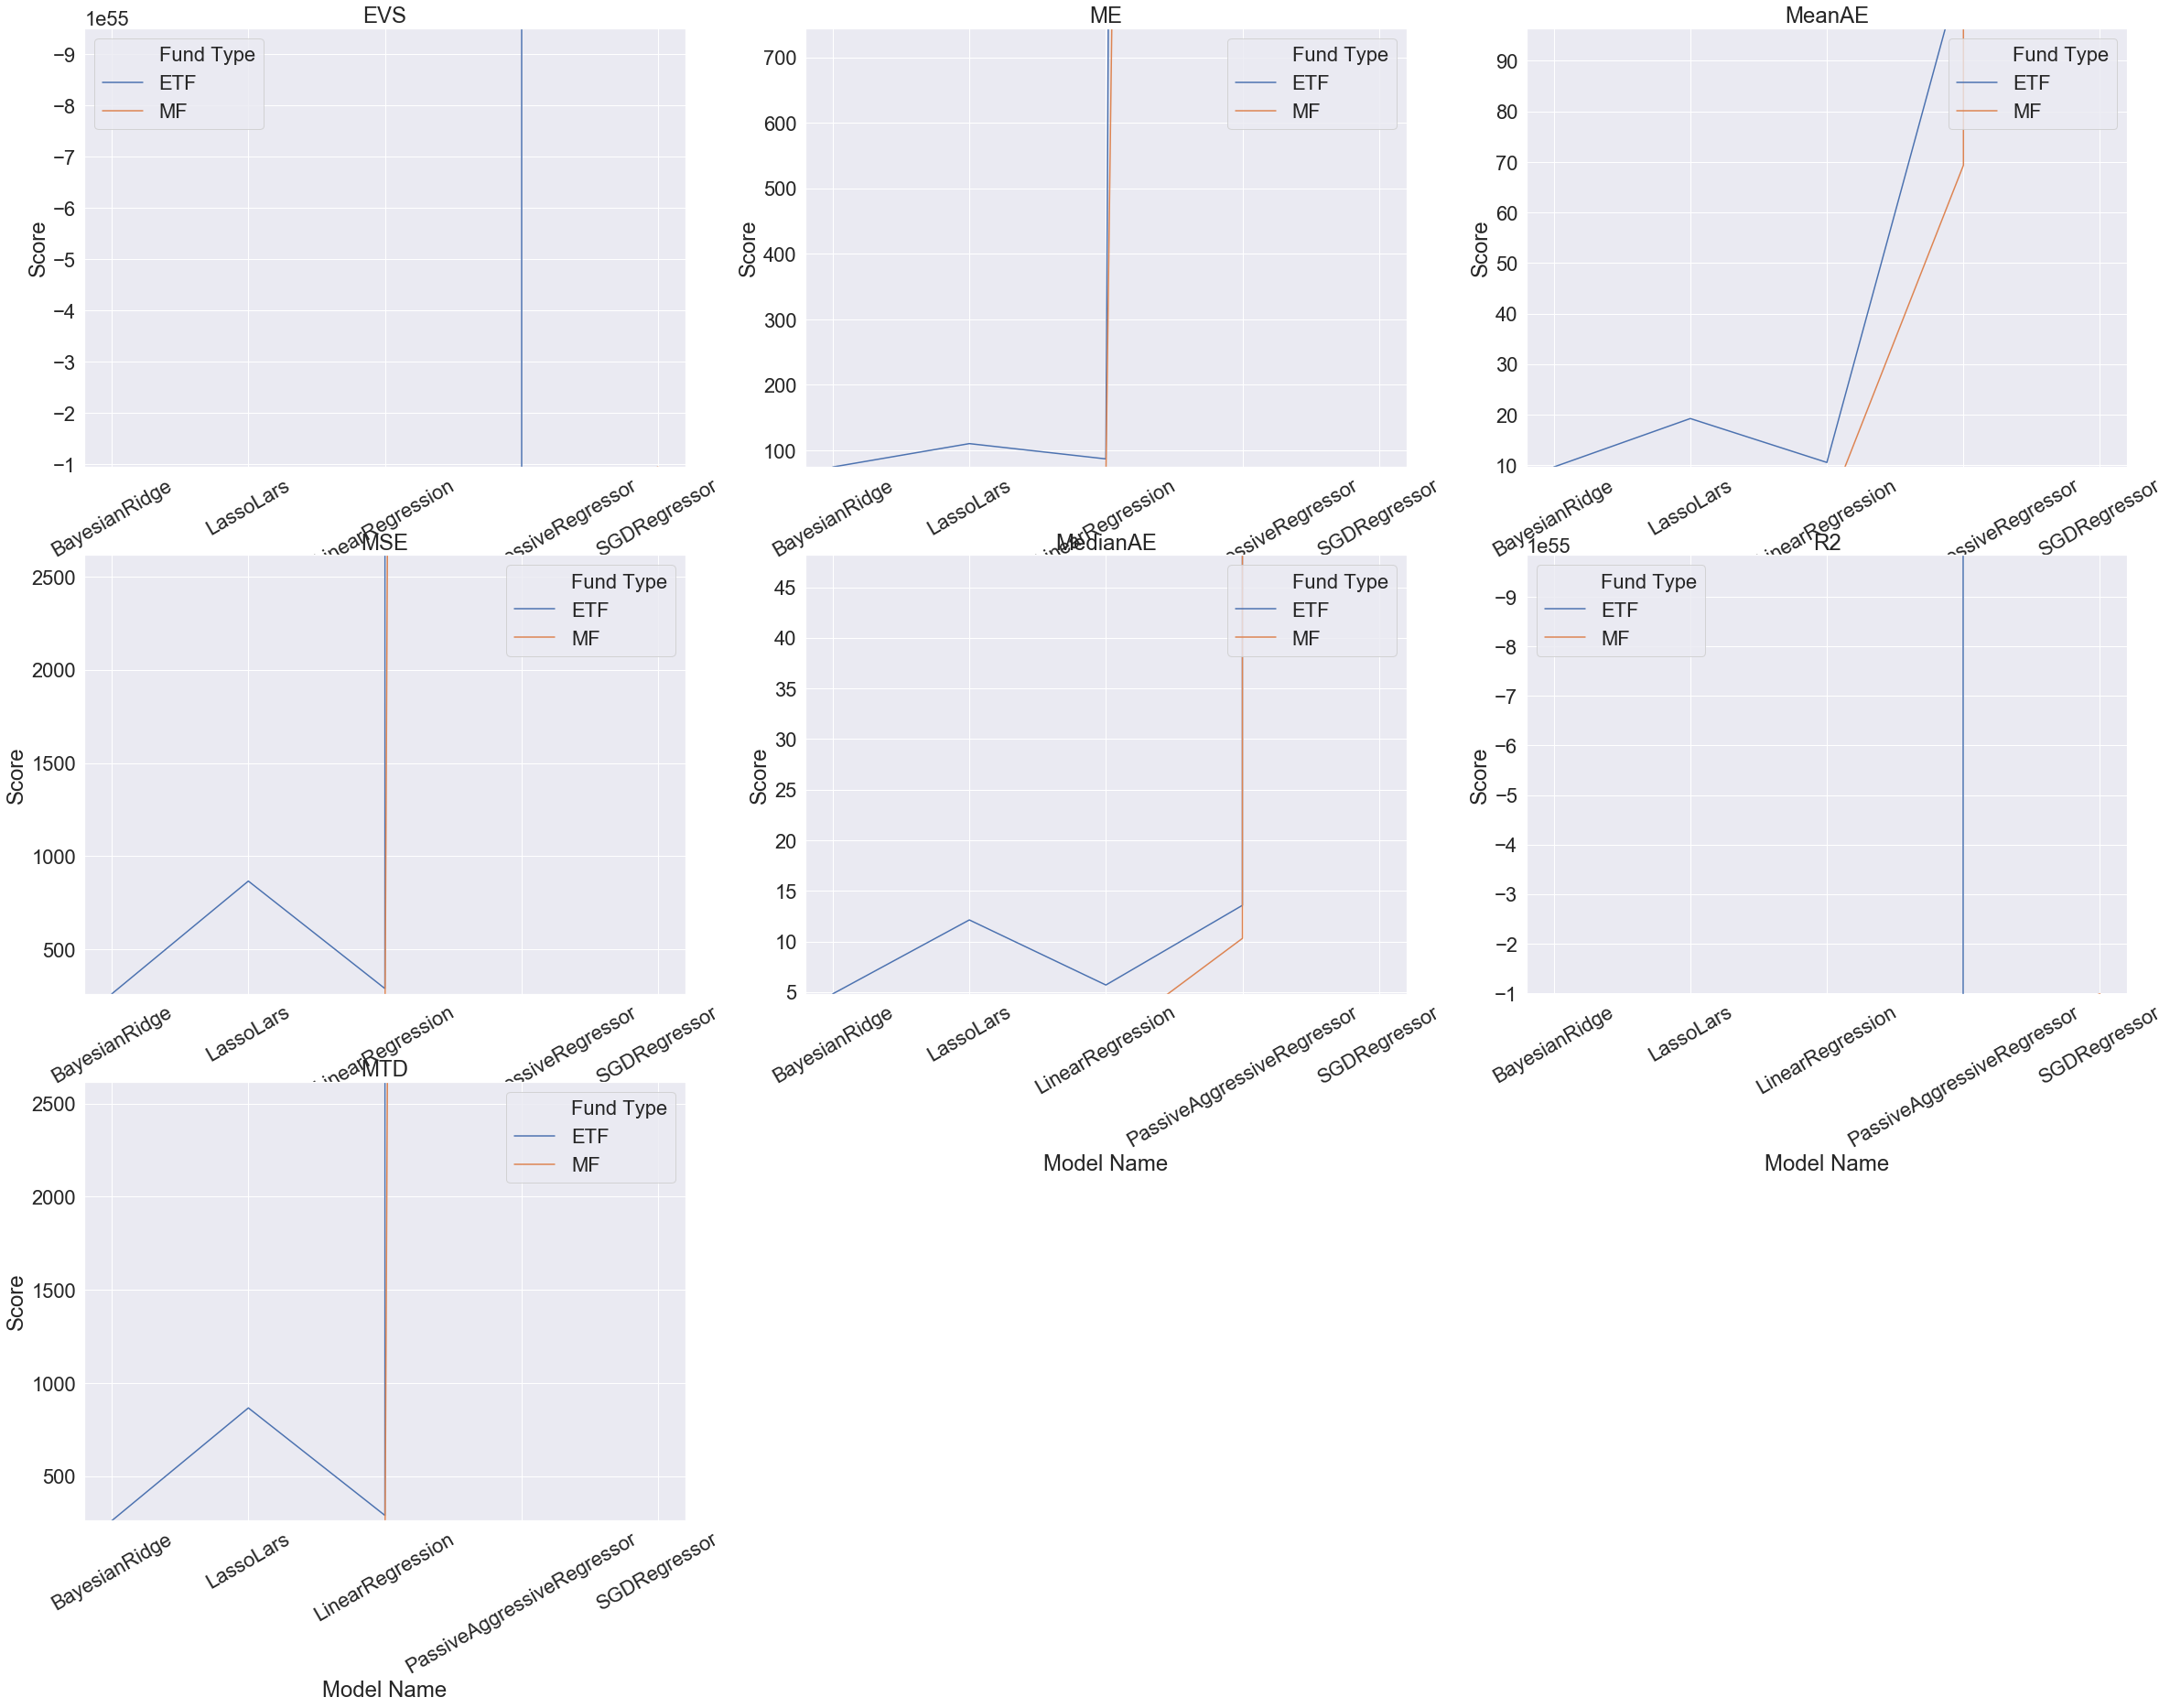

### Models

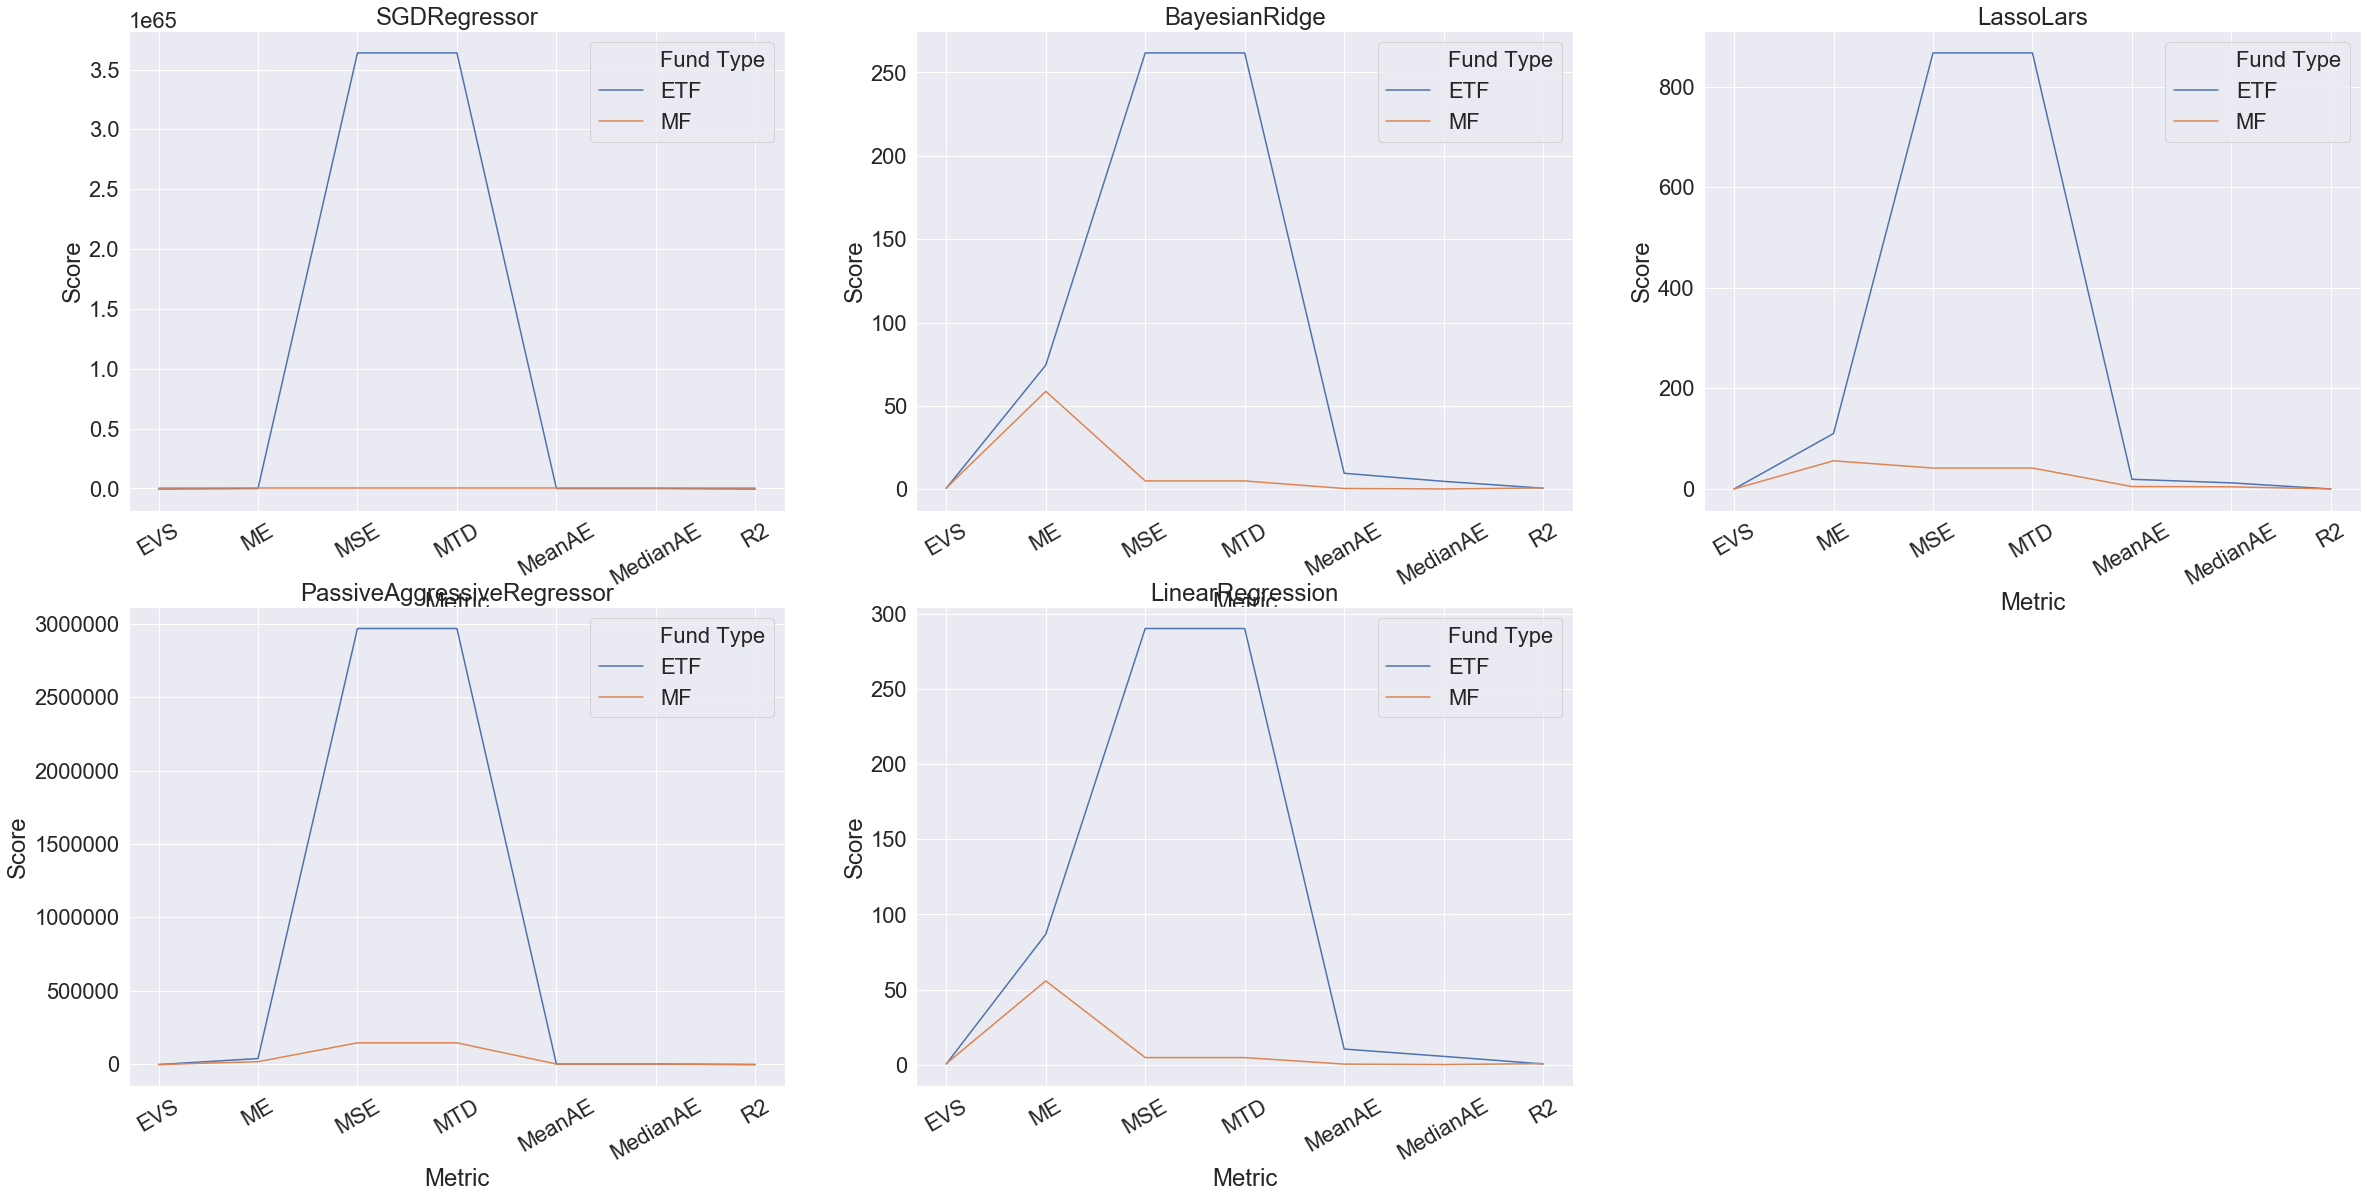

In [38]:
visualize_results(res)

### Applying Correlation clean

In [39]:
df_etf = correlation_clean(df_etf)

In [40]:
df_mf = correlation_clean(df_mf, threshold=(-0.9, -0.6, 0.6, 0.9))

In [41]:
res = {
    'ETF': {},
    'MF': {},
}
run_models(regressors, x_train, x_test, y_train, y_test, res['ETF'])

Running models...
	Model: SGDRegressor
		Explained variance score ....................... -4.5325924353265155e+56
		Max error -------------------------------------- 5.876819009778026e+30
		Mean absolute error ............................ 2.623452561678495e+28
		Mean squared error ----------------------------- 1.9530966928493854e+58
		Median absolute error .......................... 3.493905494155271e+27
		R² score, the coefficient of determination ----- -4.695611491371378e+56
		Mean Poisson, Gamma, and Tweedie deviances: .... 1.9530966928493854e+58
	Execution time: 0.168 seconds

	Model: BayesianRidge
		Explained variance score ....................... 0.8784389858339395
		Max error -------------------------------------- 58.78833679824049
		Mean absolute error ............................ 0.5312098557475394
		Mean squared error ----------------------------- 5.058901091900308
		Median absolute error .......................... 0.23833373998699603
		R² score, the coefficient of determinati

In [42]:
x_train, x_test, y_train, y_test = dataset_split(df_mf, index_col="ytd_return")

In [43]:
run_models(regressors, x_train, x_test, y_train, y_test, res['MF'])

Running models...
	Model: SGDRegressor
		Explained variance score ....................... -7.25255813196213e+57
		Max error -------------------------------------- 2.350794090291245e+31
		Mean absolute error ............................ 1.049410704635266e+29
		Mean squared error ----------------------------- 3.1251314792432115e+59
		Median absolute error .......................... 1.3976017251788104e+28
		R² score, the coefficient of determination ----- -7.513403376139191e+57
		Mean Poisson, Gamma, and Tweedie deviances: .... 3.1251314792432115e+59
	Execution time: 0.057 seconds

	Model: BayesianRidge
		Explained variance score ....................... 0.6452690110292614
		Max error -------------------------------------- 49.59840357713813
		Mean absolute error ............................ 1.8637628731822324
		Mean squared error ----------------------------- 14.754767711816745
		Median absolute error .......................... 0.9904309483793734
		R² score, the coefficient of determinatio

### Metrics

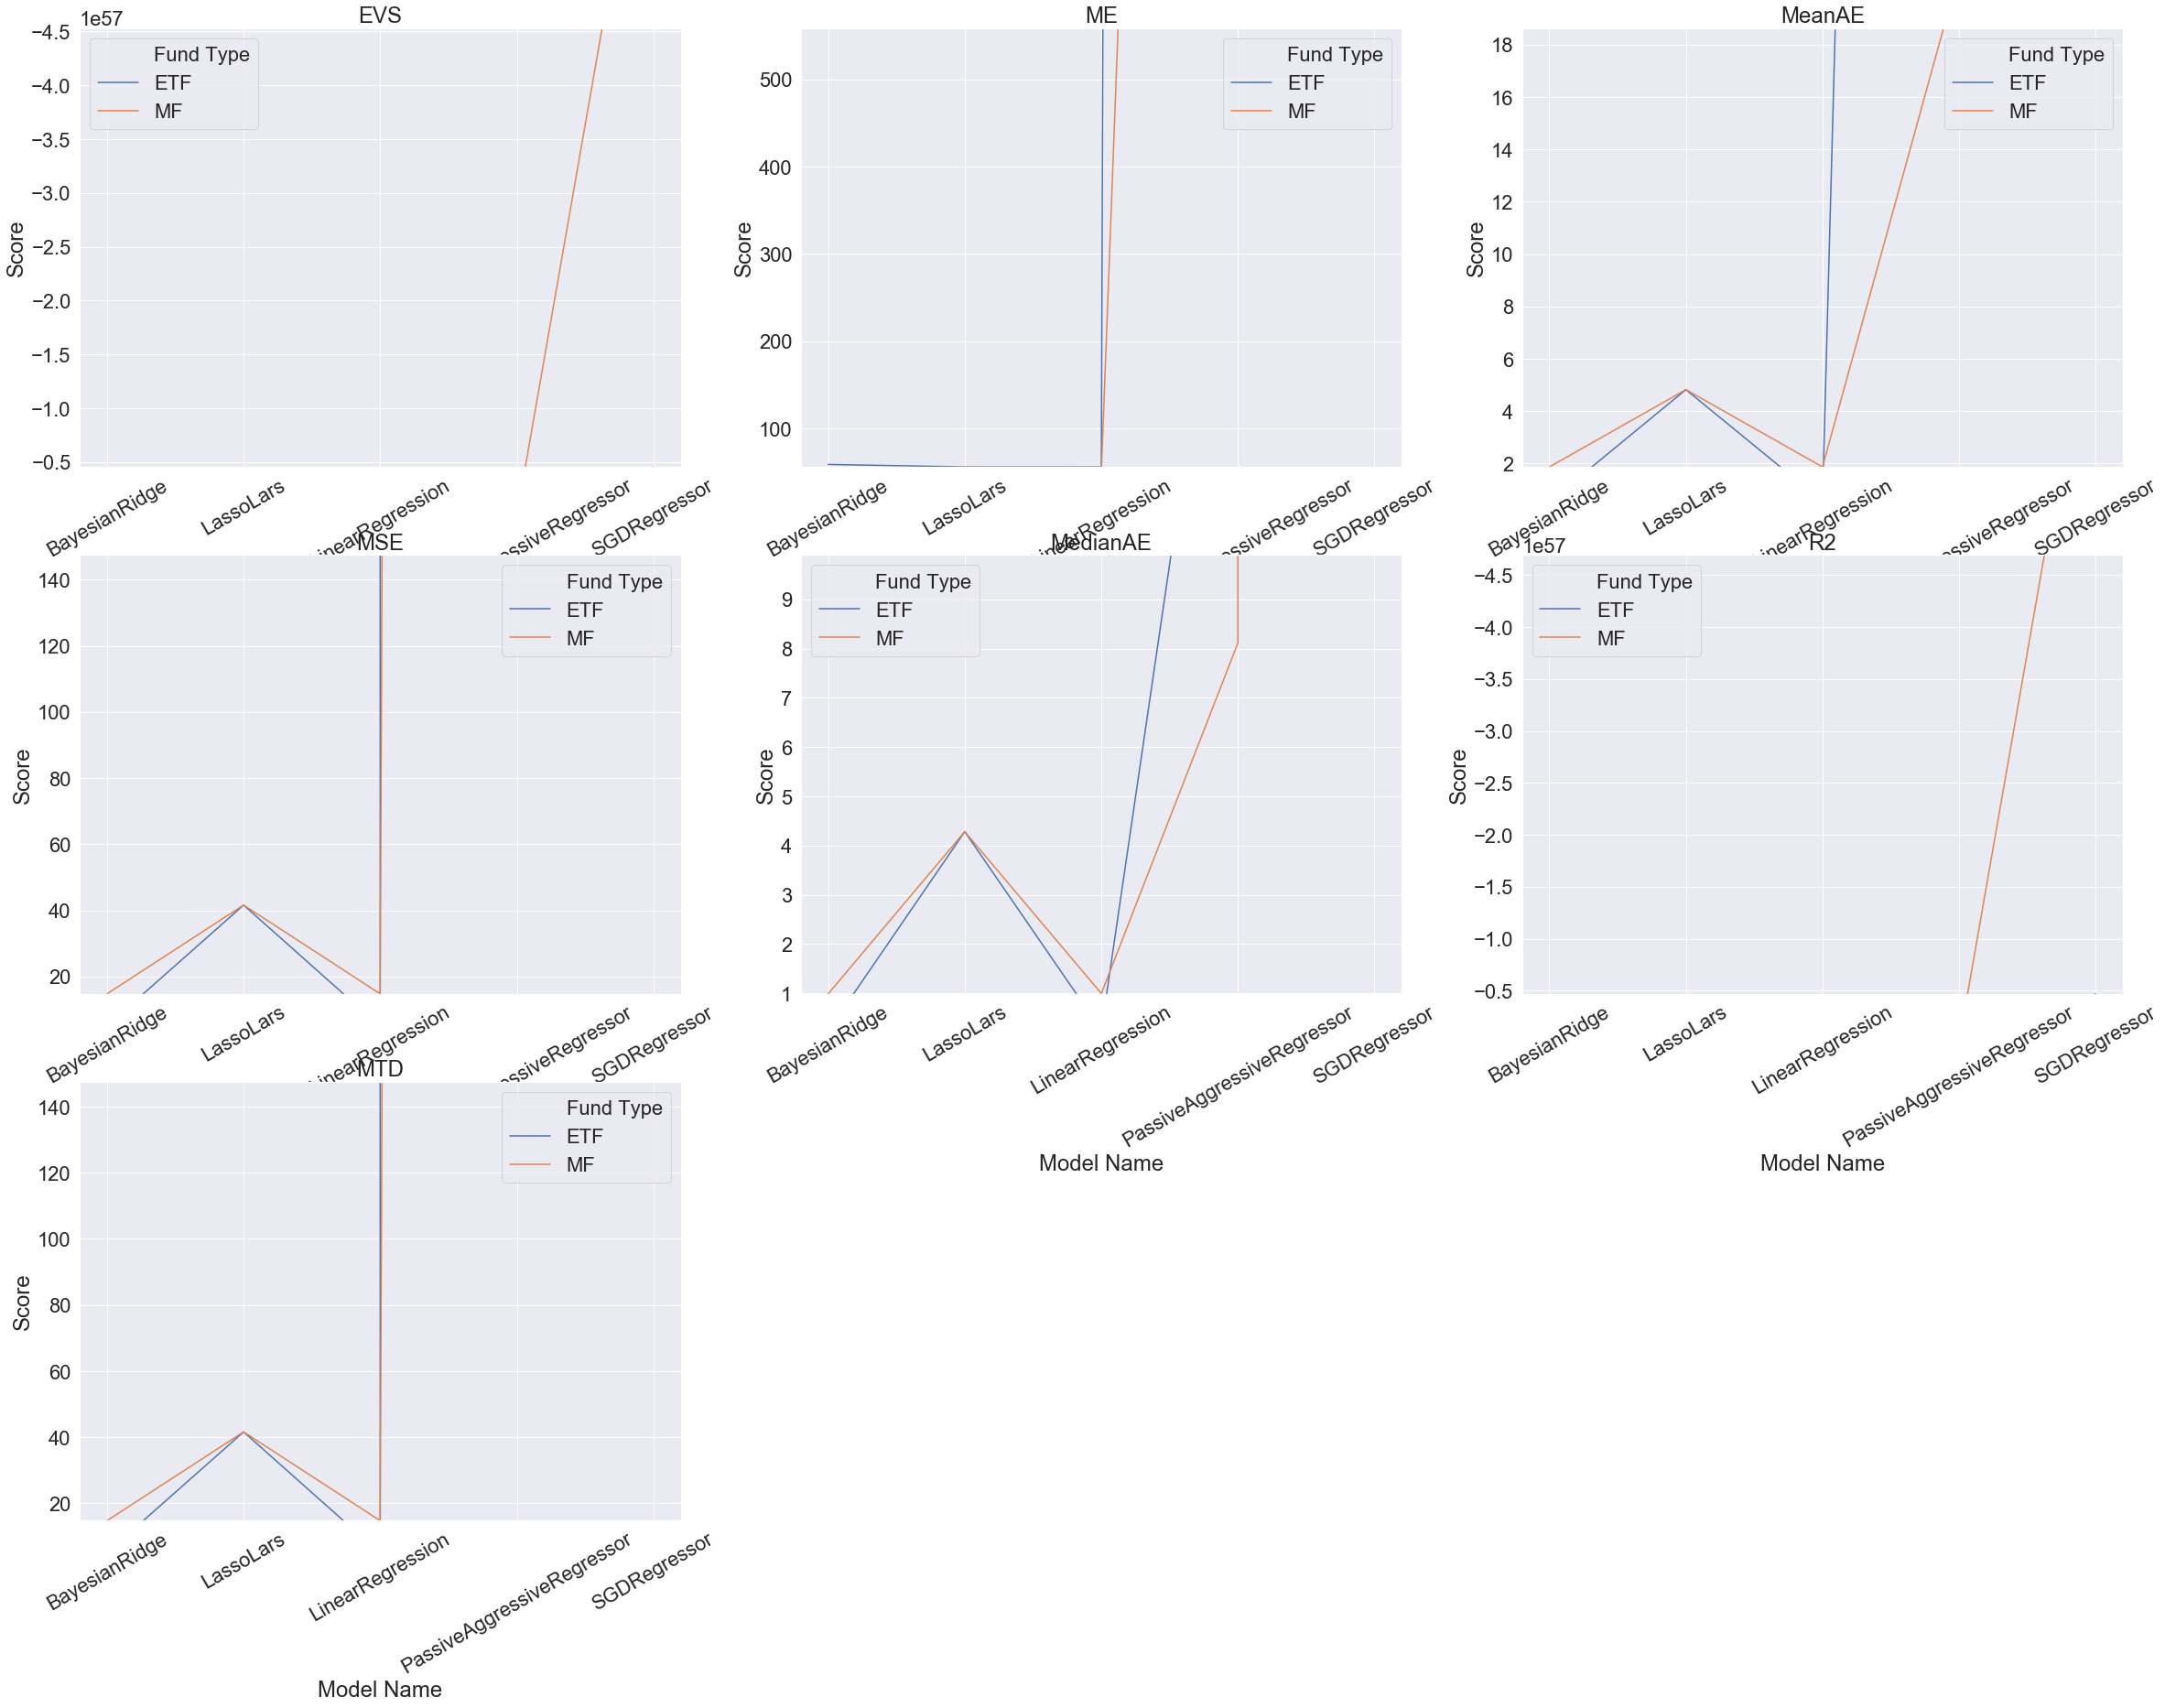

### Models

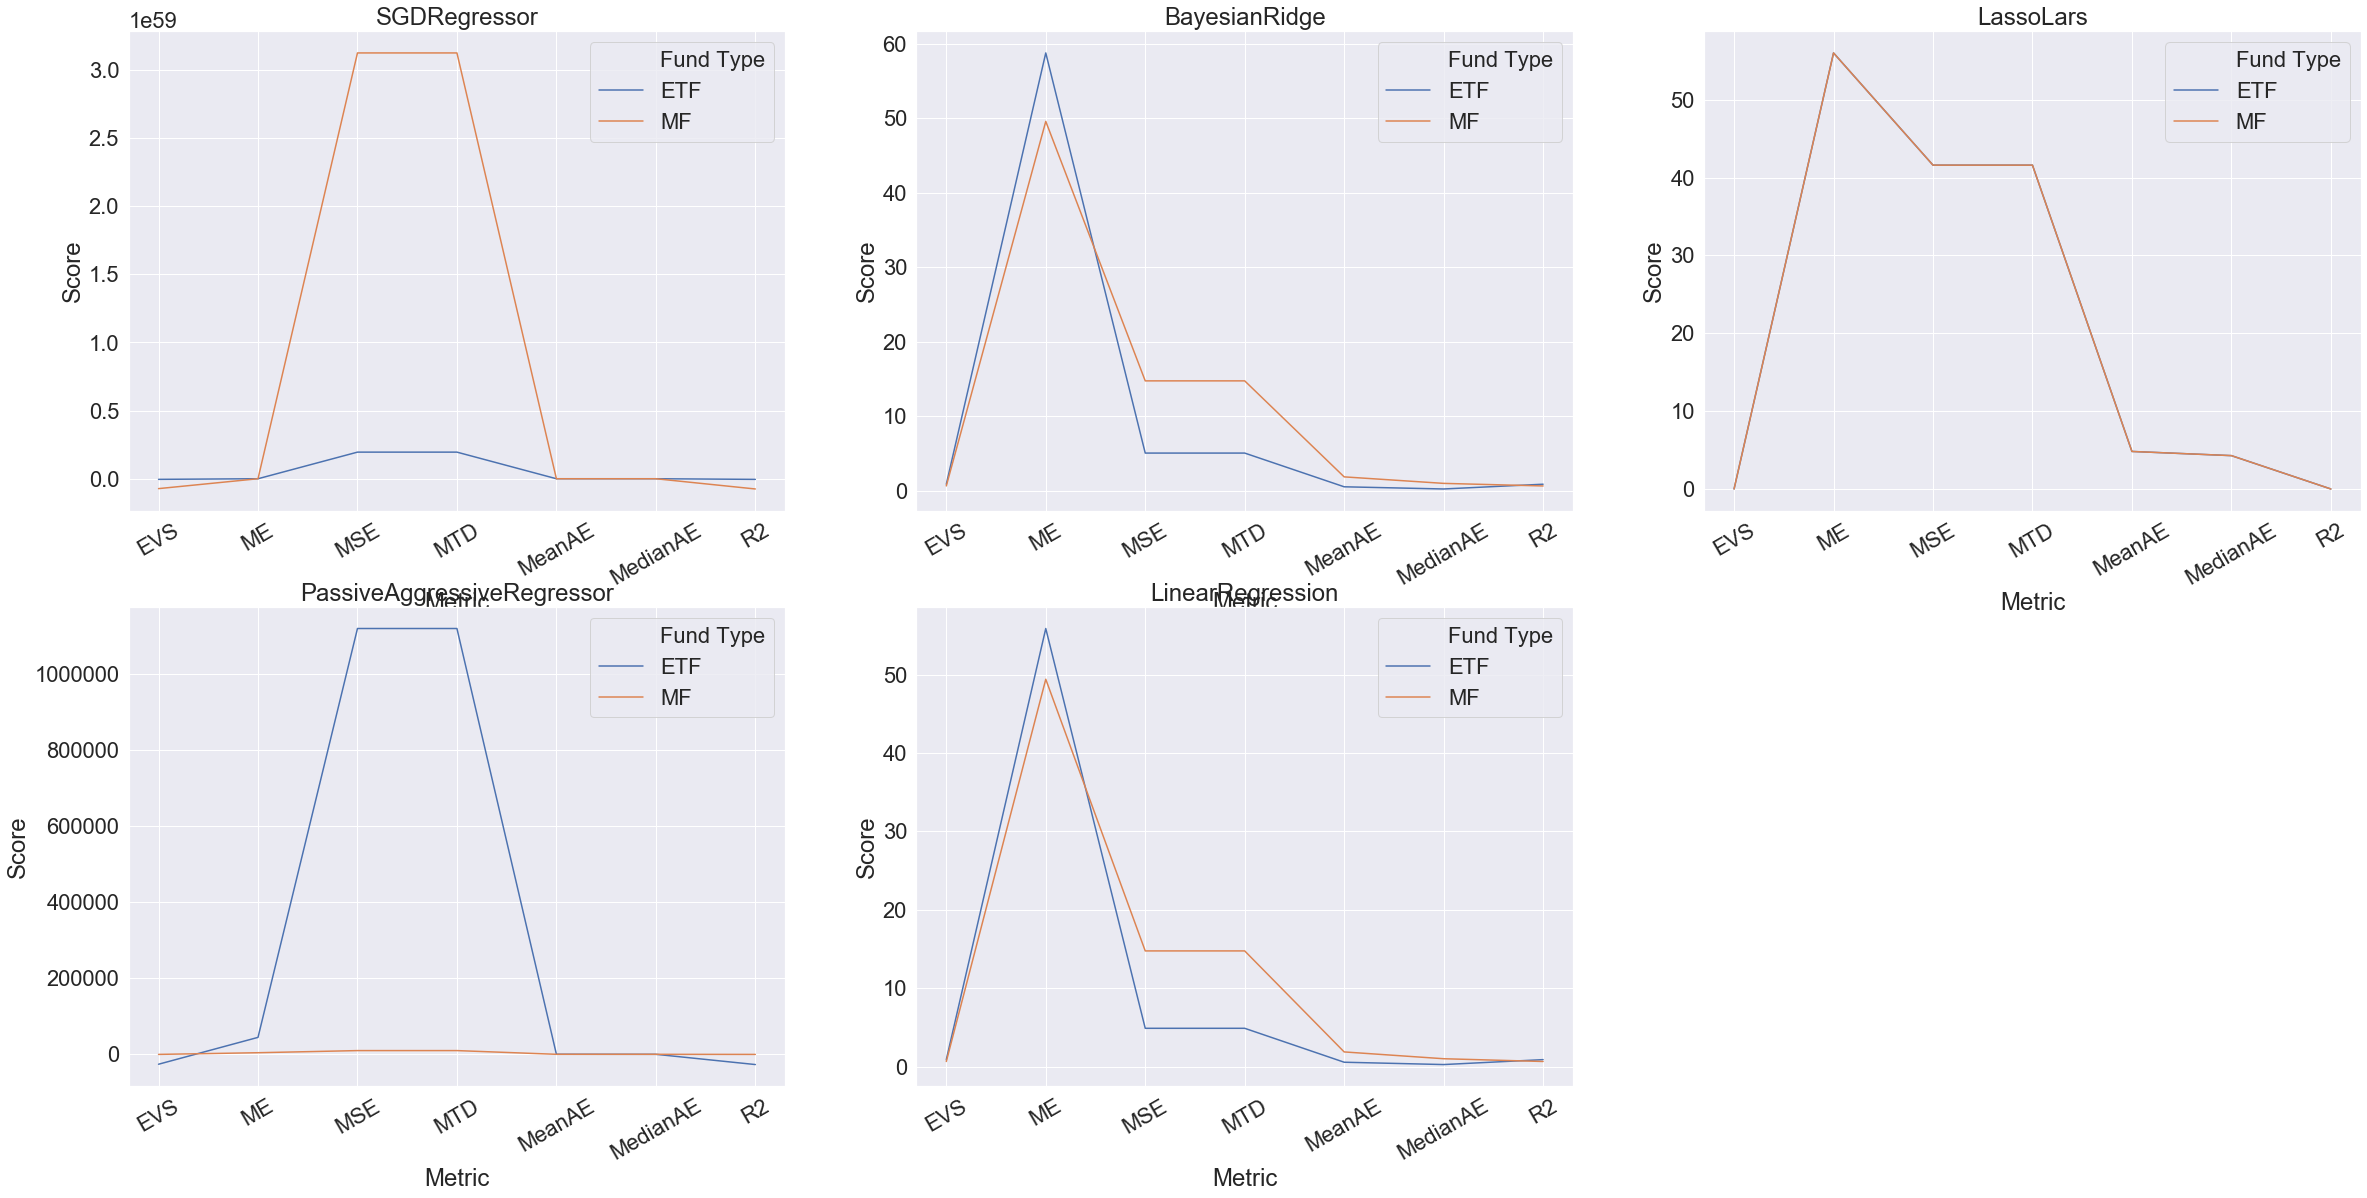

In [44]:
visualize_results(res)